In [1]:
# !pip install vincenty
# !pip install scikit-learn==0.23.2

In [478]:
# importing necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from vincenty import vincenty
import scipy.stats as stat
import pylab 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
df=pd.read_csv('train_cab.csv')

In [4]:
test=pd.read_csv('test.csv')

In [5]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [6]:
df=pd.concat([df.iloc[:,1:],df.iloc[:,0]],axis=1)
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0,4.5
1,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0,16.9
2,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0,5.7
3,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0,7.7
4,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0,5.3


In [7]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


### Assuming that test.csv dataset which is given for dependent variable prediction is perfect. We will not perform data cleaning on it i.e no observations will be removed from test.csv dataset. But we can add/remove columns to match with the train_cab.csv dataset

### We will take 4 different cases in data preprocessing

#### case1: df_1 --> drop the observations which are non sensible and remove all outliers based on boxplot.
#### case2: df_2 --> drop the observations which are non sensible , remove all outliers decided by user based on observations.
#### case3: df_3 --> make the observations which are non sensible and make all outliers (based on boxplot) to NaN and impute them.
#### case4: df_4 --> make the observations which are non sensible and make all outliers (decided by user based on observations) to NaN and impute them.

# 1.Data Cleaning

In [8]:
df.shape

(16067, 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    16067 non-null  object 
 1   pickup_longitude   16067 non-null  float64
 2   pickup_latitude    16067 non-null  float64
 3   dropoff_longitude  16067 non-null  float64
 4   dropoff_latitude   16067 non-null  float64
 5   passenger_count    16012 non-null  float64
 6   fare_amount        16043 non-null  object 
dtypes: float64(5), object(2)
memory usage: 878.8+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    9914 non-null   object 
 1   pickup_longitude   9914 non-null   float64
 2   pickup_latitude    9914 non-null   float64
 3   dropoff_longitude  9914 non-null   float64
 4   dropoff_latitude   9914 non-null   float64
 5   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


In [11]:
# creating a function for dropping rows/columns
def drop(df,index,axis):
    print("Shape of dataset before dropping:",df.shape,"\n")
    df=df.drop(index,axis=axis).reset_index(drop=True)
    print("Shape of dataset after dropping:",df.shape)
    return(df.copy())

## 1.1 fare_amount (target variable)

#### Since fare_amount is the target variable , whichever fare_amount observation that are non sensible will be removed. We won't be changing those observations to NaN and impute them.

In [12]:
try:
    df['fare_amount'].astype(float)
except Exception as e:
    print("Error:",e)

Error: could not convert string to float: '430-'


### From this error we will come to know that in one of the observations the fare_amount value is '430-'

In [13]:
df[df['fare_amount']=='430-']

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1123,2009-09-22 19:01:01 UTC,-73.97961,40.771326,-73.975764,40.781965,1.0,430-


#### Changing 430- to 430

In [14]:
df.loc[1123,'fare_amount']=430

In [15]:
df.loc[1123,'fare_amount']

430

In [16]:
df['fare_amount']=df['fare_amount'].astype(float)

In [17]:
df['fare_amount'].describe()

count    16043.000000
mean        15.040871
std        430.459997
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

#### Checking whether fare_amount <=0

In [18]:
df[df['fare_amount']<=0]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2039,2010-03-09 23:37:10 UTC,-73.789450,40.643498,-73.788665,40.641952,1.0,-2.9
2486,2015-03-22 05:14:27 UTC,-74.000031,40.720631,-73.999809,40.720539,1.0,-2.5
10002,2010-02-15 14:26:01 UTC,-73.987115,40.738808,-74.005911,40.713960,1.0,0.0
13032,2013-08-30 08:57:10 UTC,-73.995062,40.740755,-73.995885,40.741357,4.0,-3.0


In [19]:
index=df[df['fare_amount']<=0].index
index

Int64Index([2039, 2486, 10002, 13032], dtype='int64')

In [20]:
df=drop(df,index,0)

Shape of dataset before dropping: (16067, 7) 

Shape of dataset after dropping: (16063, 7)


## 1.2 pickup_datetime

In [21]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'],errors='coerce')

In [22]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],errors='coerce')

In [23]:
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,4.5
1,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,16.9
2,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,5.7
3,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,7.7
4,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,5.3


## 1.3 pickup_longitude

In [24]:
df['pickup_longitude'].describe()

count    16063.000000
mean       -72.462419
std         10.579675
min        -74.438233
25%        -73.992154
50%        -73.981696
75%        -73.966838
max         40.766125
Name: pickup_longitude, dtype: float64

## 1.4 pickup_latitude

In [25]:
df['pickup_latitude'].describe()

count    16063.000000
mean        39.914527
std          6.827426
min        -74.006893
25%         40.734935
50%         40.752615
75%         40.767382
max        401.083332
Name: pickup_latitude, dtype: float64

#### Since latitude ranges between -90 to +90 degrees, we have to remove those latitudes >90 degrees (case1 and case2) or we have to change those values to NaN (case 3 and case4)

#### Upto now our case1 observations = case2 obs and case3 obs = case4 obs. So dividing the main data(df) to case1(df_1) and case3(df_3) 

In [26]:
df_1=df.copy()
df_3=df.copy()

### 1.4.1 case 1 and case 2

In [27]:
df_1[df_1['pickup_latitude']>90]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
5684,2011-07-30 11:15:00+00:00,-73.947235,401.083332,-73.951392,40.778927,1.0,3.3


In [28]:
index=df_1[df_1['pickup_latitude']>90].index
index

Int64Index([5684], dtype='int64')

In [29]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (16063, 7) 

Shape of dataset after dropping: (16062, 7)


### 1.4.2 case 3 and case 4

In [30]:
df_3[df_3['pickup_latitude']>90]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
5684,2011-07-30 11:15:00+00:00,-73.947235,401.083332,-73.951392,40.778927,1.0,3.3


In [31]:
df_3.loc[df_3['pickup_latitude']>90,'pickup_latitude']=np.nan

In [32]:
df_3.shape

(16063, 7)

## 1.5 dropoff_longitude

### 1.5.1 case 1 and case 2

In [33]:
df_1['dropoff_longitude'].describe()

count    16062.000000
mean       -72.461865
std         10.576675
min        -74.429332
25%        -73.991182
50%        -73.980170
75%        -73.963643
max         40.802437
Name: dropoff_longitude, dtype: float64

### 1.5.2 case 3 and case 4

In [34]:
df_3['dropoff_longitude'].describe()

count    16063.000000
mean       -72.461958
std         10.576352
min        -74.429332
25%        -73.991182
50%        -73.980168
75%        -73.963642
max         40.802437
Name: dropoff_longitude, dtype: float64

## 1.6 dropoff_latitude

### 1.6.1 case 1 and case 2

In [35]:
df_1['dropoff_latitude'].describe()

count    16062.000000
mean        39.897650
std          6.188033
min        -74.006377
25%         40.734662
50%         40.753576
75%         40.768015
max         41.366138
Name: dropoff_latitude, dtype: float64

### 1.6.2 case 3 and case 4

In [36]:
df_3['dropoff_latitude'].describe()

count    16063.000000
mean        39.897705
std          6.187844
min        -74.006377
25%         40.734662
50%         40.753577
75%         40.768021
max         41.366138
Name: dropoff_latitude, dtype: float64

## 1.7 passenger_count

In [37]:
test['passenger_count'].describe()

count    9914.000000
mean        1.671273
std         1.278747
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

### 1.7.1 case 1 and case 2

In [38]:
df_1['passenger_count'].describe()

count    16007.000000
mean         2.625390
std         60.853618
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       5345.000000
Name: passenger_count, dtype: float64

In [39]:
# checking for passenger_count>6
df_1[(df_1['passenger_count'])>6].sort_values('passenger_count')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1043,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0,5.7
8628,2012-12-10 22:28:00+00:00,-73.955445,40.670232,-74.004795,40.731477,43.0,20.0
1242,2011-10-16 00:22:00+00:00,-73.981095,40.738160,-73.990587,40.740105,43.0,5.3
8403,2010-08-25 11:41:00+00:00,0.000000,0.000000,0.000000,0.000000,53.0,6.9
1007,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0,3.7
413,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0,NaN
8442,2009-03-28 22:00:00+00:00,-73.982413,40.751320,-73.971292,40.748502,58.0,5.7
8568,2011-12-03 03:21:00+00:00,-73.993718,40.762039,-73.977527,40.734024,87.0,12.5
233,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0,8.5
1107,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0,4.9


In [40]:
index=df_1[(df_1['passenger_count'])>6].index
index

Int64Index([ 233,  263,  293,  356,  386,  413,  971, 1007, 1043, 1107, 1146,
            1200, 1242, 8403, 8442, 8503, 8568, 8628, 8712, 8982],
           dtype='int64')

In [41]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (16062, 7) 

Shape of dataset after dropping: (16042, 7)


In [42]:
df_1['passenger_count'].value_counts()

1.00    11255
2.00     2322
5.00     1045
3.00      676
4.00      328
6.00      302
0.00       57
0.12        1
1.30        1
Name: passenger_count, dtype: int64

In [43]:
df_1[(df_1['passenger_count']==0) | (df_1['passenger_count']==1.30) | (df_1['passenger_count']==0.12)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
311,2015-06-02 23:16:15+00:00,-73.974899,40.751095,-73.908546,40.881878,0.00,34.0
560,2012-01-28 21:33:18+00:00,-73.955322,40.782840,-73.955797,40.773673,0.00,4.9
672,2012-02-27 07:24:20+00:00,-73.983397,40.738183,-73.971395,40.758023,0.00,6.5
1149,2011-05-25 23:58:48+00:00,-73.998360,40.740348,-73.946455,40.777348,0.00,13.3
1922,2011-10-23 11:09:28+00:00,-73.971400,40.795000,-73.967900,40.768600,0.00,10.1
2186,2011-05-23 16:54:19+00:00,-73.988008,40.748303,-74.005185,40.738733,0.00,8.1
2411,2011-11-25 22:47:33+00:00,-73.999900,40.738600,-73.971800,40.746300,0.00,8.9
3019,2011-03-06 12:03:14+00:00,-73.986557,40.745783,-73.994545,40.729995,0.00,5.7
3398,2011-02-28 06:39:16+00:00,-73.973413,40.743708,-73.985220,40.741583,0.00,7.3
3466,2011-11-30 17:23:02+00:00,-73.968100,40.762500,-73.984400,40.760900,0.00,11.3


In [44]:
index=df_1[(df_1['passenger_count']==0) | (df_1['passenger_count']==1.30) | (df_1['passenger_count']==0.12)].index
index

Int64Index([  311,   560,   672,  1149,  1922,  2186,  2411,  3019,  3398,
             3466,  3474,  3584,  4099,  4233,  4329,  4339,  5043,  5135,
             5146,  5262,  5502,  5542,  5672,  5898,  6020,  6559,  6697,
             6865,  7263,  7504,  7624,  7893,  8305,  8640,  8768,  8840,
             8894,  8949,  9136,  9942, 10618, 10639, 10687, 11438, 11779,
            12192, 12587, 13005, 13202, 13354, 13689, 13717, 14171, 14283,
            14847, 15261, 15489, 15529, 15894],
           dtype='int64')

In [45]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (16042, 7) 

Shape of dataset after dropping: (15983, 7)


### 1.7.2 case 3 and case 4

In [46]:
df_3['passenger_count'].describe()

count    16008.000000
mean         2.625289
std         60.851718
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       5345.000000
Name: passenger_count, dtype: float64

In [47]:
df_3[df_3['passenger_count']>6].sort_values('passenger_count')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1043,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0,5.7
8629,2012-12-10 22:28:00+00:00,-73.955445,40.670232,-74.004795,40.731477,43.0,20.0
1242,2011-10-16 00:22:00+00:00,-73.981095,40.738160,-73.990587,40.740105,43.0,5.3
8404,2010-08-25 11:41:00+00:00,0.000000,0.000000,0.000000,0.000000,53.0,6.9
1007,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0,3.7
413,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0,NaN
8443,2009-03-28 22:00:00+00:00,-73.982413,40.751320,-73.971292,40.748502,58.0,5.7
8569,2011-12-03 03:21:00+00:00,-73.993718,40.762039,-73.977527,40.734024,87.0,12.5
233,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0,8.5
1107,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0,4.9


In [48]:
df_3.loc[df_3['passenger_count']>6,'passenger_count']=np.nan

In [49]:
df_3.shape

(16063, 7)

In [50]:
df_3['passenger_count'].value_counts()

1.00    11256
2.00     2322
5.00     1045
3.00      676
4.00      328
6.00      302
0.00       57
0.12        1
1.30        1
Name: passenger_count, dtype: int64

In [51]:
df_3.loc[(df_3['passenger_count']==0) | (df_3['passenger_count']==1.30) | (df_3['passenger_count']==0.12),'passenger_count']=np.nan

In [52]:
df_3.shape

(16063, 7)

## 1.8 Cleaning of pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude variables combined

#### Since latitude=0 and longitude=0 is located in ocean we can remove them in case 1 and case 2. 
#### Since both latitude and longitude which are zero will be converted to NaN , imputation will be inaccurate. so we will remove them in case 3 and case 4 also.

### 1.8.1 case 1 and case 2

In [53]:
index=[]
for i in range(len(df_1)):
    a=df_1.loc[i,'pickup_longitude']
    b=df_1.loc[i,'pickup_latitude']
    c=df_1.loc[i,'dropoff_longitude']
    d=df_1.loc[i,'dropoff_latitude']
    if ((a==0 and b==0) or (c==0 and d==0)):
        index.append(i)  
index        

[11,
 15,
 26,
 124,
 192,
 271,
 352,
 371,
 381,
 465,
 491,
 533,
 535,
 560,
 652,
 719,
 790,
 863,
 872,
 878,
 949,
 951,
 955,
 957,
 1243,
 1297,
 1299,
 1380,
 1424,
 1525,
 1544,
 1578,
 1620,
 1664,
 1687,
 1762,
 1766,
 1806,
 1811,
 1829,
 1993,
 2124,
 2208,
 2377,
 2426,
 2427,
 2434,
 2497,
 2499,
 2520,
 2700,
 2725,
 2777,
 2859,
 2863,
 2938,
 2942,
 2986,
 3105,
 3144,
 3145,
 3171,
 3285,
 3334,
 3337,
 3338,
 3351,
 3409,
 3441,
 3481,
 3511,
 3684,
 3733,
 3738,
 3779,
 3803,
 3839,
 3862,
 3864,
 3881,
 3887,
 4020,
 4186,
 4249,
 4399,
 4424,
 4430,
 4442,
 4482,
 4543,
 4566,
 4569,
 4575,
 4628,
 4709,
 4746,
 4768,
 4827,
 4857,
 4862,
 5091,
 5104,
 5178,
 5194,
 5204,
 5429,
 5430,
 5505,
 5524,
 5549,
 5552,
 5598,
 5627,
 5639,
 5732,
 5740,
 5757,
 5838,
 5920,
 5946,
 5967,
 5984,
 6017,
 6109,
 6136,
 6147,
 6256,
 6261,
 6285,
 6588,
 6604,
 6701,
 6716,
 6718,
 6824,
 6866,
 6960,
 6965,
 6979,
 7034,
 7235,
 7248,
 7271,
 7315,
 7326,
 7365,
 7374

In [54]:
len(index)

320

In [55]:
df_1.loc[index]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
11,2012-12-24 11:24:00+00:00,0.0,0.0,0.0,0.0,3.0,5.5
15,2013-11-23 12:57:00+00:00,0.0,0.0,0.0,0.0,1.0,5.0
26,2011-02-07 20:01:00+00:00,0.0,0.0,0.0,0.0,1.0,NaN
124,2013-01-17 17:22:00+00:00,0.0,0.0,0.0,0.0,2.0,8.0
192,2010-09-05 17:08:00+00:00,0.0,0.0,0.0,0.0,5.0,3.7
...,...,...,...,...,...,...,...
15836,2012-05-18 04:44:00+00:00,0.0,0.0,0.0,0.0,1.0,8.1
15845,2010-05-18 20:34:00+00:00,0.0,0.0,0.0,0.0,5.0,10.9
15853,2009-10-01 20:32:00+00:00,0.0,0.0,0.0,0.0,3.0,3.3
15930,2011-03-04 14:05:00+00:00,0.0,0.0,0.0,0.0,2.0,10.9


In [56]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15983, 7) 

Shape of dataset after dropping: (15663, 7)


In [57]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15663 entries, 0 to 15662
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15662 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15663 non-null  float64            
 2   pickup_latitude    15663 non-null  float64            
 3   dropoff_longitude  15663 non-null  float64            
 4   dropoff_latitude   15663 non-null  float64            
 5   passenger_count    15608 non-null  float64            
 6   fare_amount        15642 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 856.7 KB


### 1.8.2 case 3 and case 4

In [58]:
index=[]
for i in range(len(df_3)):
    a=df_3.loc[i,'pickup_longitude']
    b=df_3.loc[i,'pickup_latitude']
    c=df_3.loc[i,'dropoff_longitude']
    d=df_3.loc[i,'dropoff_latitude']
    if ((a==0 and b==0) or (c==0 and d==0)):
        index.append(i)  
index        

[11,
 15,
 26,
 124,
 192,
 233,
 273,
 357,
 376,
 387,
 472,
 498,
 540,
 542,
 568,
 660,
 728,
 799,
 872,
 881,
 887,
 958,
 960,
 964,
 966,
 1260,
 1314,
 1316,
 1397,
 1441,
 1542,
 1561,
 1595,
 1637,
 1681,
 1704,
 1779,
 1783,
 1823,
 1828,
 1846,
 2011,
 2142,
 2227,
 2396,
 2446,
 2447,
 2454,
 2517,
 2519,
 2540,
 2720,
 2745,
 2797,
 2879,
 2883,
 2958,
 2962,
 3006,
 3126,
 3165,
 3166,
 3192,
 3306,
 3355,
 3358,
 3359,
 3372,
 3431,
 3463,
 3505,
 3535,
 3709,
 3758,
 3763,
 3804,
 3828,
 3864,
 3887,
 3889,
 3906,
 3912,
 4045,
 4212,
 4276,
 4428,
 4453,
 4459,
 4471,
 4511,
 4572,
 4595,
 4598,
 4604,
 4657,
 4738,
 4775,
 4797,
 4856,
 4886,
 4891,
 5121,
 5134,
 5210,
 5226,
 5236,
 5462,
 5463,
 5539,
 5559,
 5584,
 5587,
 5633,
 5662,
 5674,
 5769,
 5777,
 5794,
 5875,
 5958,
 5984,
 6005,
 6022,
 6056,
 6148,
 6175,
 6186,
 6295,
 6300,
 6324,
 6628,
 6644,
 6742,
 6757,
 6759,
 6865,
 6908,
 7002,
 7007,
 7021,
 7076,
 7278,
 7291,
 7314,
 7358,
 7369,
 7408,

In [59]:
df_3.loc[index]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
11,2012-12-24 11:24:00+00:00,0.0,0.0,0.0,0.0,3.0,5.5
15,2013-11-23 12:57:00+00:00,0.0,0.0,0.0,0.0,1.0,5.0
26,2011-02-07 20:01:00+00:00,0.0,0.0,0.0,0.0,1.0,NaN
124,2013-01-17 17:22:00+00:00,0.0,0.0,0.0,0.0,2.0,8.0
192,2010-09-05 17:08:00+00:00,0.0,0.0,0.0,0.0,5.0,3.7
...,...,...,...,...,...,...,...
15916,2012-05-18 04:44:00+00:00,0.0,0.0,0.0,0.0,1.0,8.1
15925,2010-05-18 20:34:00+00:00,0.0,0.0,0.0,0.0,5.0,10.9
15933,2009-10-01 20:32:00+00:00,0.0,0.0,0.0,0.0,3.0,3.3
16010,2011-03-04 14:05:00+00:00,0.0,0.0,0.0,0.0,2.0,10.9


In [60]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (16063, 7) 

Shape of dataset after dropping: (15739, 7)


In [61]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15739 entries, 0 to 15738
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15738 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15739 non-null  float64            
 2   pickup_latitude    15738 non-null  float64            
 3   dropoff_longitude  15739 non-null  float64            
 4   dropoff_latitude   15739 non-null  float64            
 5   passenger_count    15609 non-null  float64            
 6   fare_amount        15717 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 860.9 KB


# 2.Checking for missing values

In [62]:
# for case1,case2
pd.DataFrame(pd.concat([df_1.isnull().sum(),df_1.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
passenger_count,55,0.351146
fare_amount,21,0.134074
pickup_datetime,1,0.006384
pickup_longitude,0,0.000000
pickup_latitude,0,0.000000
dropoff_longitude,0,0.000000
dropoff_latitude,0,0.000000


In [63]:
# for case3,case4
pd.DataFrame(pd.concat([df_3.isnull().sum(),df_3.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
passenger_count,130,0.825974
fare_amount,22,0.139780
pickup_datetime,1,0.006354
pickup_latitude,1,0.006354
pickup_longitude,0,0.000000
dropoff_longitude,0,0.000000
dropoff_latitude,0,0.000000


## 2.1 fare_amount

#### Since fare_amount is a target variable we are only dropping the missing values

### 2.1.1 case 1 and case 2

In [64]:
df_1[df_1['fare_amount'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
8,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1.0,NaN
66,2015-05-12 23:51:42+00:00,-73.954796,40.779335,-73.944931,40.780087,1.0,NaN
122,2013-09-17 04:22:00+00:00,-73.987210,40.729325,-73.931985,40.697207,1.0,NaN
164,2009-01-16 21:10:00+00:00,-73.994143,40.751193,-73.988897,40.759742,1.0,NaN
234,2009-06-20 19:28:37+00:00,-73.979345,40.776630,-73.973842,40.757074,1.0,NaN
296,2014-07-11 05:07:00+00:00,-73.951660,40.772657,-74.010583,40.721405,2.0,NaN
340,2014-09-05 15:23:00+00:00,-73.968260,40.765140,-73.961115,40.774882,6.0,NaN
439,2014-07-03 01:34:00+00:00,-73.968087,40.755140,-73.952622,40.823312,5.0,NaN
644,2014-06-25 23:08:56+00:00,-73.977865,40.784274,-73.962362,40.767125,2.0,NaN
679,2012-05-21 11:37:42+00:00,-73.992170,40.764320,-73.966214,40.762562,1.0,NaN


In [65]:
index=df_1[df_1['fare_amount'].isnull()].index
index

Int64Index([   8,   66,  122,  164,  234,  296,  340,  439,  644,  679,  721,
             810,  814,  884, 1526, 1579, 1660, 2348, 2390, 7973, 8021],
           dtype='int64')

In [66]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15663, 7) 

Shape of dataset after dropping: (15642, 7)


### 2.1.2 case 3 and case 4

In [67]:
df_3[df_3['fare_amount'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
8,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1.0,NaN
66,2015-05-12 23:51:42+00:00,-73.954796,40.779335,-73.944931,40.780087,1.0,NaN
122,2013-09-17 04:22:00+00:00,-73.987210,40.729325,-73.931985,40.697207,1.0,NaN
164,2009-01-16 21:10:00+00:00,-73.994143,40.751193,-73.988897,40.759742,1.0,NaN
234,2009-06-20 19:28:37+00:00,-73.979345,40.776630,-73.973842,40.757074,1.0,NaN
298,2014-07-11 05:07:00+00:00,-73.951660,40.772657,-74.010583,40.721405,2.0,NaN
343,2014-09-05 15:23:00+00:00,-73.968260,40.765140,-73.961115,40.774882,6.0,NaN
403,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,NaN,NaN
445,2014-07-03 01:34:00+00:00,-73.968087,40.755140,-73.952622,40.823312,5.0,NaN
651,2014-06-25 23:08:56+00:00,-73.977865,40.784274,-73.962362,40.767125,2.0,NaN


In [68]:
index=df_3[df_3['fare_amount'].isnull()].index
index

Int64Index([   8,   66,  122,  164,  234,  298,  343,  403,  445,  651,  687,
             729,  818,  822,  892, 1542, 1595, 1676, 2366, 2409, 8018, 8066],
           dtype='int64')

In [69]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (15739, 7) 

Shape of dataset after dropping: (15717, 7)


## 2.2 passenger_count

### 2.2.1 case 1 and case 2

In [70]:
df_1[df_1['passenger_count'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
27,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,40.660366,NaN,22.54
60,2011-11-07 10:47:40+00:00,-74.003919,40.753019,-73.992368,40.735362,NaN,7.30
77,2013-06-14 08:27:43+00:00,-73.953710,40.790813,-73.957015,40.777676,NaN,8.50
92,2014-12-07 12:26:00+00:00,-73.984977,40.752122,-74.000925,40.757982,NaN,9.00
107,2012-12-06 18:05:00+00:00,-73.953310,40.787772,-73.944352,40.719772,NaN,35.00
126,2012-02-03 13:46:35+00:00,-73.988006,40.737723,-73.965699,40.766095,NaN,10.50
143,2010-05-17 07:44:00+00:00,-73.950972,40.785633,-74.010240,40.720302,NaN,17.30
166,2015-02-27 07:50:56+00:00,-73.944023,40.775959,-73.955048,40.785080,NaN,10.50
186,2014-02-05 00:28:00+00:00,-73.996652,40.744495,-73.980253,40.737635,NaN,16.00
194,2012-04-25 20:39:00+00:00,-73.993973,40.746577,-74.005060,40.709365,NaN,11.30


In [71]:
index=df_1[df_1['passenger_count'].isnull()].index
index

Int64Index([   27,    60,    77,    92,   107,   126,   143,   166,   186,
              194,   209,   423,   443,   469,   507,   508,   542,   543,
              544,   545,   546,   547,   596,   631,   665,   699,   737,
              752,   803,   857,   898,  1303,  1340,  1341,  1399,  1679,
             1719,  1777,  1847,  1909,  1912,  2027,  2150,  2298,  7568,
             7586,  7628,  7673,  7717,  7786,  7854,  7915,  8032,  8078,
            15641],
           dtype='int64')

In [72]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15642, 7) 

Shape of dataset after dropping: (15587, 7)


In [73]:
df_1['passenger_count']=pd.to_numeric(df_1['passenger_count']).astype('int64')

In [74]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15587 entries, 0 to 15586
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15586 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15587 non-null  float64            
 2   pickup_latitude    15587 non-null  float64            
 3   dropoff_longitude  15587 non-null  float64            
 4   dropoff_latitude   15587 non-null  float64            
 5   passenger_count    15587 non-null  int64              
 6   fare_amount        15587 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 852.5 KB


### 2.2.2 case3 and case4

In [75]:
df_3[df_3['passenger_count'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
27,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,40.660366,NaN,22.54
60,2011-11-07 10:47:40+00:00,-74.003919,40.753019,-73.992368,40.735362,NaN,7.30
77,2013-06-14 08:27:43+00:00,-73.953710,40.790813,-73.957015,40.777676,NaN,8.50
92,2014-12-07 12:26:00+00:00,-73.984977,40.752122,-74.000925,40.757982,NaN,9.00
107,2012-12-06 18:05:00+00:00,-73.953310,40.787772,-73.944352,40.719772,NaN,35.00
...,...,...,...,...,...,...,...
14544,2011-03-02 19:25:46+00:00,-73.948553,40.773972,-73.945098,40.778413,NaN,3.30
14951,2012-03-20 22:23:34+00:00,-73.971808,40.760143,-73.962027,40.767677,NaN,4.90
15175,2012-02-12 02:03:50+00:00,-73.999342,40.718872,-73.984112,40.725242,NaN,6.50
15215,2011-08-03 08:31:19+00:00,-73.991700,40.750100,-73.981000,40.750900,NaN,6.50


In [76]:
df_3.loc[34,'passenger_count']

6.0

In [77]:
df_3.loc[34,'passenger_count']=np.nan

In [78]:
np.round(df_3['passenger_count'].mean())

2.0

In [79]:
df_3['passenger_count'].median()

1.0

In [80]:
df_3['passenger_count'].mode()[0]

1.0

In [81]:
from sklearn.impute import KNNImputer

In [82]:
pd.DataFrame(np.round(KNNImputer(n_neighbors=3).fit_transform(df_3.iloc[:,1:])),columns=df_3.columns[1:]).loc[34,'passenger_count']

4.0

In [83]:
df_3.loc[34,'passenger_count']=6

In [84]:
## Actual value for the 34th obs = 6
## Mean imputation = 2
## Median imputation = 1
## Mode imputation = 1
## KNN imputation at k=3 = 4

# Based on this KNN imputation is the best

## 2.3 pickup_datetime

#### Since we can derive more new features out of pickup_datetime, it's better to drop the missing value of pickup_datetime which is only one value in number

### 2.3.1 case 1 and case 2

In [85]:
df_1[df_1['pickup_datetime'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1238,NaT,-73.981947,40.7282,-73.988582,40.759202,1,11.5


In [86]:
index=df_1[df_1['pickup_datetime'].isnull()].index
index

Int64Index([1238], dtype='int64')

In [87]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15587, 7) 

Shape of dataset after dropping: (15586, 7)


In [88]:
df_1.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

### 2.3.2 case 3 and case 4

In [89]:
df_3[df_3['pickup_datetime'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1284,NaT,-73.981947,40.7282,-73.988582,40.759202,1.0,11.5


In [90]:
index=df_3[df_3['pickup_datetime'].isnull()].index
index

Int64Index([1284], dtype='int64')

In [91]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (15717, 7) 

Shape of dataset after dropping: (15716, 7)


## 2.4 pickup_latitude

### 2.4.1 For case3 and case4

In [92]:
df_3[df_3['pickup_latitude'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
5548,2011-07-30 11:15:00+00:00,-73.947235,NaN,-73.951392,40.778927,1.0,3.3


In [93]:
df_3.loc[100,'pickup_latitude']

40.74732

In [94]:
df_3.loc[100,'pickup_latitude']=np.nan

In [95]:
df_3['pickup_latitude'].mean()

40.68989377406347

In [96]:
df_3['pickup_latitude'].median()

40.753294

In [97]:
pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df_3.iloc[:,1:]),columns=df_3.columns[1:]).loc[100,'pickup_latitude']

40.74762533333334

In [98]:
# Actual Value for 100th obs = 40.74732
# Mean imputation = 40.6898
# Median imputation = 40.7532
# KNN imputation at k=3 = 40.7476

# Based on this KNN imputation is the best

In [99]:
df_3.loc[100,'pickup_latitude']=40.74732

## 2.5 Imputation of missing values

### 2.5.1 For case 3 and case 4

In [100]:
df_3_testing=pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df_3.iloc[:,1:]),columns=df_3.columns[1:])

In [101]:
df_3=pd.concat([df_3.iloc[:,0],df_3_testing],axis=1)

In [102]:
df_3['passenger_count'].value_counts()

1.000000    11051
2.000000     2293
5.000000     1024
3.000000      668
4.000000      320
6.000000      295
1.333333       28
1.666667       14
2.333333       12
2.666667        5
3.666667        5
3.333333        1
Name: passenger_count, dtype: int64

In [103]:
df_3['passenger_count']=np.round(df_3['passenger_count'])

In [104]:
df_3['passenger_count'].value_counts()

1.0    11079
2.0     2319
5.0     1024
3.0      674
4.0      325
6.0      295
Name: passenger_count, dtype: int64

In [105]:
df_3.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

In [106]:
df_3['passenger_count']=pd.to_numeric(df_3['passenger_count']).astype('int64')

In [107]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15716 entries, 0 to 15715
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15716 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15716 non-null  float64            
 2   pickup_latitude    15716 non-null  float64            
 3   dropoff_longitude  15716 non-null  float64            
 4   dropoff_latitude   15716 non-null  float64            
 5   passenger_count    15716 non-null  int64              
 6   fare_amount        15716 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 859.6 KB


# 3.Outlier Analysis

In [108]:
#### Since in outlier analysis case 1 will not be equal to case 2 and case 3 will not be equal to case 4
df_2=df_1.copy()
df_4=df_3.copy()

## 3.1 pickup_longitude

### 3.1.1 case 1

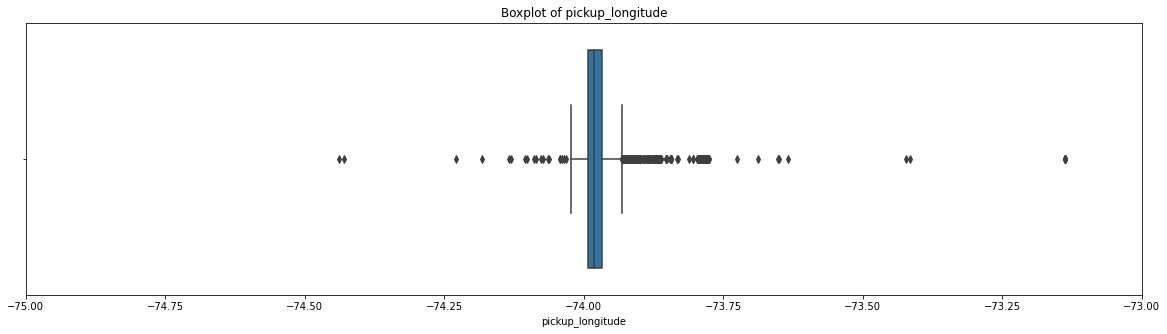

In [109]:
plt.figure(figsize=(20,5)) 
plt.xlim(-75,-73)
sns.boxplot(x=df_1['pickup_longitude'],data=df_1,orient='h')
plt.title('Boxplot of pickup_longitude')
plt.show()

In [110]:
q75,q25=np.percentile(df_1.loc[:,"pickup_longitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -74.02885038125 max: -73.93157377125


In [111]:
df_1[(df_1['pickup_longitude']>max) | (df_1['pickup_longitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,4.50
27,2009-01-09 16:10:00+00:00,-73.873027,40.773883,-73.984545,40.769545,3,31.90
78,2011-08-31 08:21:47+00:00,-73.917399,40.746485,-73.973756,40.763836,1,12.50
96,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,52.00
108,2012-05-11 15:03:53+00:00,-73.872862,40.774105,-73.970593,40.764393,2,32.50
...,...,...,...,...,...,...,...
15495,2009-12-20 14:13:00+00:00,-73.791823,40.645207,-73.952637,40.767205,1,49.57
15497,2012-04-26 17:05:54+00:00,-73.783577,40.648660,-73.978550,40.762548,1,49.80
15505,2009-08-25 21:53:00+00:00,-73.876153,40.772007,-73.981828,40.781113,1,25.30
15535,2010-05-28 02:58:00+00:00,-73.920900,40.756573,-73.815065,40.705340,3,30.50


In [112]:
index=df_1[(df_1['pickup_longitude']>max) | (df_1['pickup_longitude']<min)].index
index

Int64Index([    0,    27,    78,    96,   108,   113,   152,   176,   180,
              185,
            ...
            15408, 15422, 15427, 15433, 15488, 15495, 15497, 15505, 15535,
            15544],
           dtype='int64', length=804)

In [113]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15586, 7) 

Shape of dataset after dropping: (14782, 7)


### 3.1.2 case 2

In [114]:
df_2['pickup_longitude'].describe()

count    15586.000000
mean       -73.911174
std          2.665436
min        -74.438233
25%        -73.992372
50%        -73.982042
75%        -73.968052
max         40.766125
Name: pickup_longitude, dtype: float64

In [115]:
df_2[(df_2['pickup_longitude']>-73.137)].sort_values('pickup_longitude',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6468,2013-05-22 15:33:00+00:00,40.766125,-73.983285,40.757417,-73.977962,2,13.0
9228,2013-07-13 12:31:00+00:00,40.764420,-73.992947,40.802437,-73.950730,1,15.5
7267,2013-05-22 10:54:00+00:00,40.760495,-73.973047,40.740367,-73.994392,1,13.0
2026,2013-05-24 14:54:00+00:00,40.751582,-73.986968,40.758867,-73.978353,2,5.0
4592,2013-05-22 06:28:00+00:00,40.748262,-73.991840,40.740372,-73.979010,1,6.5
9757,2013-05-22 20:15:00+00:00,40.736875,-74.006210,40.736887,-74.006377,6,52.0
8156,2013-05-24 00:32:00+00:00,40.729127,-74.006893,40.763367,-73.961550,1,15.0
3661,2013-06-20 04:28:00+00:00,40.719830,-73.988467,40.723305,-73.939430,1,11.0
1097,2012-10-11 00:21:00+00:00,-0.004093,0.033500,0.016852,0.017980,2,25.0


#### By seeing the observation , pickup_longitude >-73.137 is set as outlier

In [116]:
index=df_2[(df_2['pickup_longitude']>-73.137)].index
index

Int64Index([1097, 2026, 3661, 4592, 6468, 7267, 8156, 9228, 9757], dtype='int64')

In [117]:
df_2=drop(df_2,index,0)

Shape of dataset before dropping: (15586, 7) 

Shape of dataset after dropping: (15577, 7)


### 3.1.3 case 3

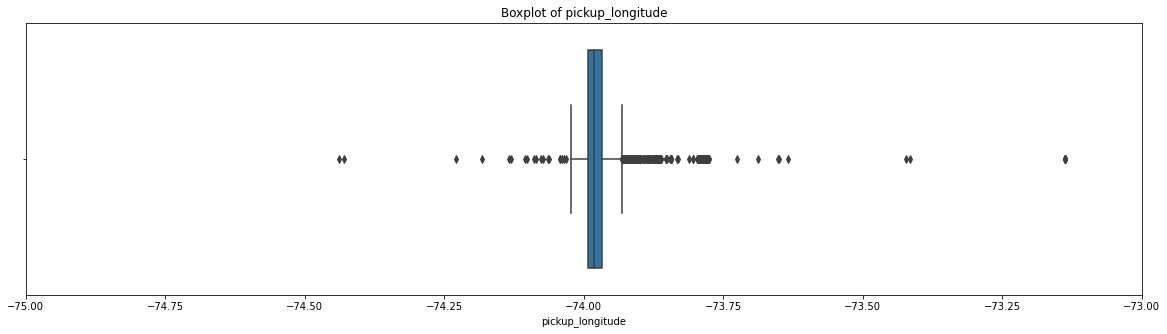

In [118]:
plt.figure(figsize=(20,5)) 
plt.xlim(-75,-73)
sns.boxplot(x=df_3['pickup_longitude'],data=df_3,orient='h')
plt.title('Boxplot of pickup_longitude')
plt.show()

In [119]:
q75,q25=np.percentile(df_3.loc[:,"pickup_longitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -74.02885237500001 max: -73.931615375


In [120]:
df_3[(df_3['pickup_longitude']>max) | (df_3['pickup_longitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,4.50
28,2009-01-09 16:10:00+00:00,-73.873027,40.773883,-73.984545,40.769545,3,31.90
81,2011-08-31 08:21:47+00:00,-73.917399,40.746485,-73.973756,40.763836,1,12.50
100,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,52.00
113,2012-05-11 15:03:53+00:00,-73.872862,40.774105,-73.970593,40.764393,2,32.50
...,...,...,...,...,...,...,...
15624,2009-12-20 14:13:00+00:00,-73.791823,40.645207,-73.952637,40.767205,1,49.57
15626,2012-04-26 17:05:54+00:00,-73.783577,40.648660,-73.978550,40.762548,1,49.80
15634,2009-08-25 21:53:00+00:00,-73.876153,40.772007,-73.981828,40.781113,1,25.30
15664,2010-05-28 02:58:00+00:00,-73.920900,40.756573,-73.815065,40.705340,3,30.50


In [121]:
df_3.loc[(df_3['pickup_longitude']>max) | (df_3['pickup_longitude']<min),'pickup_longitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

### 3.1.4 case 4

In [122]:
df_4['pickup_longitude'].describe()

count    15716.000000
mean       -73.911723
std          2.654397
min        -74.438233
25%        -73.992389
50%        -73.982050
75%        -73.968079
max         40.766125
Name: pickup_longitude, dtype: float64

In [123]:
df_4[(df_4['pickup_longitude']>-73.137)].sort_values('pickup_longitude',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6550,2013-05-22 15:33:00+00:00,40.766125,-73.983285,40.757417,-73.977962,2,13.0
9339,2013-07-13 12:31:00+00:00,40.764420,-73.992947,40.802437,-73.950730,1,15.5
7353,2013-05-22 10:54:00+00:00,40.760495,-73.973047,40.740367,-73.994392,1,13.0
2084,2013-05-24 14:54:00+00:00,40.751582,-73.986968,40.758867,-73.978353,2,5.0
4663,2013-05-22 06:28:00+00:00,40.748262,-73.991840,40.740372,-73.979010,1,6.5
9869,2013-05-22 20:15:00+00:00,40.736875,-74.006210,40.736887,-74.006377,6,52.0
8255,2013-05-24 00:32:00+00:00,40.729127,-74.006893,40.763367,-73.961550,1,15.0
3728,2013-06-20 04:28:00+00:00,40.719830,-73.988467,40.723305,-73.939430,1,11.0
1141,2012-10-11 00:21:00+00:00,-0.004093,0.033500,0.016852,0.017980,2,25.0


#### By seeing the observation , pickup_longitude >-73.137 is set as outlier

In [124]:
df_4.loc[(df_4['pickup_longitude']>-73.137),'pickup_longitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

## 3.2 pickup_latitude

### 3.2.1 case 1

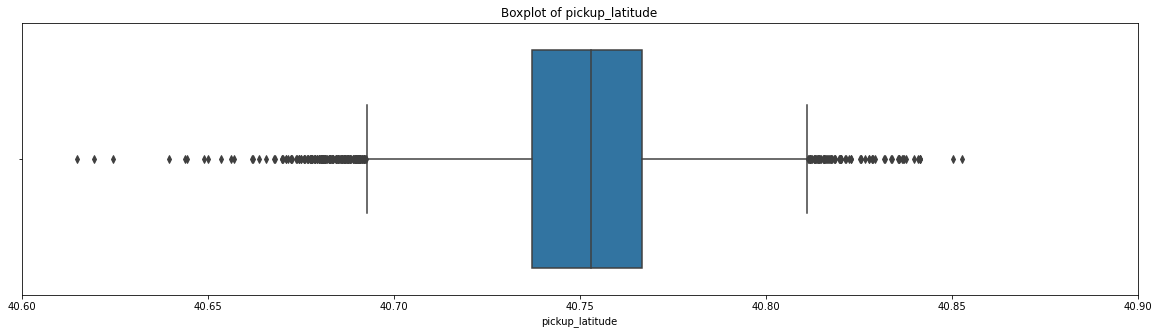

In [125]:
plt.figure(figsize=(20,5)) 
plt.xlim(40.6,40.9)
sns.boxplot(x=df_1['pickup_latitude'],data=df_1,orient='h')
plt.title('Boxplot of pickup_latitude')
plt.show()

In [126]:
q75,q25=np.percentile(df_1.loc[:,"pickup_latitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: 40.692700125 max: 40.81113312500001


In [127]:
df_1[(df_1['pickup_latitude']>max) | (df_1['pickup_latitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
23,2012-05-04 06:11:20+00:00,-73.989258,40.690835,-74.004133,40.725690,1,9.3
74,2014-03-21 11:00:29+00:00,-73.950688,40.828531,-73.964101,40.808140,1,8.0
113,2014-09-12 23:10:00+00:00,-73.983837,40.676052,-74.002522,40.723145,1,16.5
134,2009-07-16 20:33:00+00:00,-73.980755,40.680558,-73.989110,40.726788,2,12.9
279,2009-01-26 00:44:42+00:00,-73.994279,40.690409,-74.016739,40.709063,1,10.6
...,...,...,...,...,...,...,...
14126,2010-05-06 08:57:00+00:00,-73.954058,40.821483,-73.988980,40.756983,1,17.3
14440,2013-08-13 20:32:00+00:00,-73.956427,40.818390,-73.965502,40.800962,1,7.5
14445,2010-05-19 21:48:00+00:00,-73.983860,40.676007,-73.983083,40.672987,1,3.3
14455,2014-03-30 18:05:00+00:00,-73.990385,40.686905,-73.973727,40.682937,1,9.0


In [128]:
index=df_1[(df_1['pickup_latitude']>max) | (df_1['pickup_latitude']<min)].index
index

Int64Index([   23,    74,   113,   134,   279,   307,   440,   499,   613,
              646,
            ...
            13547, 13573, 13734, 13871, 13925, 14126, 14440, 14445, 14455,
            14543],
           dtype='int64', length=260)

In [129]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (14782, 7) 

Shape of dataset after dropping: (14522, 7)


### 3.2.2 case 2

In [130]:
df_2['pickup_latitude'].describe()

count    15577.000000
mean        40.750921
std          0.038021
min         39.603178
25%         40.736588
50%         40.753350
75%         40.767807
max         41.366138
Name: pickup_latitude, dtype: float64

#### By seeing the observation , there is no outlier in pickup_latitude

### 3.2.3 case 3

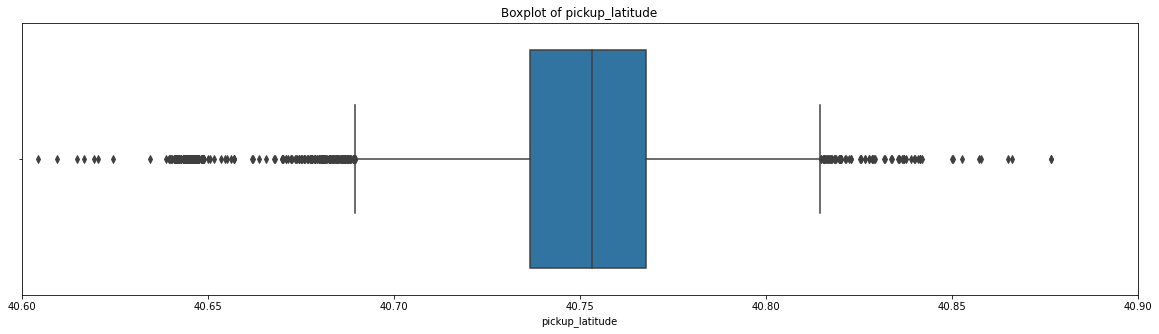

In [131]:
plt.figure(figsize=(20,5)) 
plt.xlim(40.6,40.9)
sns.boxplot(x=df_3['pickup_latitude'],data=df_3,orient='h')
plt.title('Boxplot of pickup_latitude')
plt.show()

In [132]:
q75,q25=np.percentile(df_3.loc[:,"pickup_latitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: 40.689670500000005 max: 40.81467649999999


In [133]:
df_3[(df_3['pickup_latitude']>max) | (df_3['pickup_latitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
79,2014-03-21 11:00:29+00:00,-73.950688,40.828531,-73.964101,40.808140,1,8.00
124,2014-09-12 23:10:00+00:00,-73.983837,40.676052,-74.002522,40.723145,1,16.50
147,2009-07-16 20:33:00+00:00,-73.980755,40.680558,-73.989110,40.726788,2,12.90
240,2010-05-28 21:33:07+00:00,NaN,40.647040,-73.815622,40.680364,1,16.10
274,2013-06-14 17:37:00+00:00,NaN,40.645007,-73.981802,40.762515,1,57.33
...,...,...,...,...,...,...,...
15556,2011-10-24 06:19:00+00:00,NaN,40.644745,-73.975865,40.688232,1,32.90
15562,2011-11-20 12:58:00+00:00,NaN,40.616788,-73.928838,40.616788,2,12.50
15624,2009-12-20 14:13:00+00:00,NaN,40.645207,-73.952637,40.767205,1,49.57
15626,2012-04-26 17:05:54+00:00,NaN,40.648660,-73.978550,40.762548,1,49.80


In [134]:
df_3.loc[(df_3['pickup_latitude']>max) | (df_3['pickup_latitude']<min),'pickup_latitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

### 3.2.4 case 4

In [135]:
df_4['pickup_latitude'].describe()

count    15716.000000
mean        40.689903
std          2.608731
min        -74.006893
25%         40.736548
50%         40.753294
75%         40.767799
max         41.366138
Name: pickup_latitude, dtype: float64

In [136]:
df_4[df_4['pickup_latitude']<39.6].sort_values('pickup_latitude')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
8255,2013-05-24 00:32:00+00:00,NaN,-74.006893,40.763367,-73.961550,1,15.0
9869,2013-05-22 20:15:00+00:00,NaN,-74.006210,40.736887,-74.006377,6,52.0
9339,2013-07-13 12:31:00+00:00,NaN,-73.992947,40.802437,-73.950730,1,15.5
4663,2013-05-22 06:28:00+00:00,NaN,-73.991840,40.740372,-73.979010,1,6.5
3728,2013-06-20 04:28:00+00:00,NaN,-73.988467,40.723305,-73.939430,1,11.0
2084,2013-05-24 14:54:00+00:00,NaN,-73.986968,40.758867,-73.978353,2,5.0
6550,2013-05-22 15:33:00+00:00,NaN,-73.983285,40.757417,-73.977962,2,13.0
7353,2013-05-22 10:54:00+00:00,NaN,-73.973047,40.740367,-73.994392,1,13.0
1141,2012-10-11 00:21:00+00:00,NaN,0.033500,0.016852,0.017980,2,25.0


#### By seeing the observation , pickup_latitude <39.6 is set as outlier

In [137]:
df_4.loc[df_4['pickup_latitude']<39.6,'pickup_latitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

## 3.3 dropoff_longitude

### 3.3.1 case 1

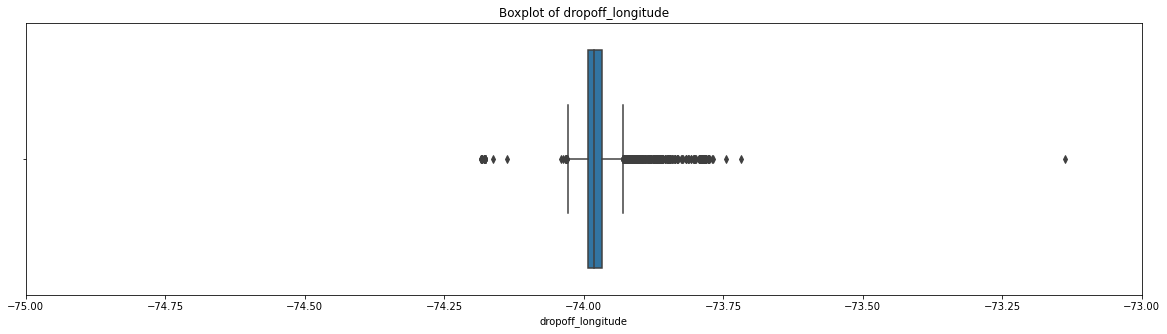

In [138]:
plt.figure(figsize=(20,5)) 
plt.xlim(-75,-73)
sns.boxplot(x=df_1['dropoff_longitude'],data=df_1,orient='h')
plt.title('Boxplot of dropoff_longitude')
plt.show()

In [139]:
q75,q25=np.percentile(df_1.loc[:,"dropoff_longitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -74.02879098749996 max: -73.92959050750004


In [140]:
df_1[(df_1['dropoff_longitude']>max) | (df_1['dropoff_longitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
48,2010-05-31 18:06:00+00:00,-73.985427,40.758853,-73.872907,40.774497,1,34.67
67,2011-08-12 04:20:00+00:00,-74.006662,40.731210,-73.925940,40.825588,1,24.90
111,2009-09-22 21:14:00+00:00,-73.977023,40.752600,-73.790310,40.643783,2,49.57
112,2012-02-12 01:26:00+00:00,-73.988200,40.759090,-73.923683,40.868610,5,22.50
125,2014-05-13 22:19:00+00:00,-73.982265,40.762062,-73.768550,40.675135,1,52.50
...,...,...,...,...,...,...,...
14420,2014-04-14 21:15:33+00:00,-73.984604,40.748209,-73.869463,40.859598,1,38.00
14440,2015-04-05 10:39:11+00:00,-73.978905,40.783115,-73.871956,40.772133,2,33.50
14443,2015-04-15 21:02:56+00:00,-74.004700,40.741741,-73.808159,40.757359,2,47.04
14469,2009-09-13 01:07:20+00:00,-73.975717,40.795568,-73.922822,40.866558,2,16.10


In [141]:
index=df_1[(df_1['dropoff_longitude']>max) | (df_1['dropoff_longitude']<min)].index
index

Int64Index([   48,    67,   111,   112,   125,   151,   186,   198,   219,
              259,
            ...
            14262, 14317, 14344, 14405, 14409, 14420, 14440, 14443, 14469,
            14512],
           dtype='int64', length=663)

In [142]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (14522, 7) 

Shape of dataset after dropping: (13859, 7)


### 3.3.2 case 2

In [143]:
df_2['dropoff_longitude'].describe()

count    15577.000000
mean       -73.960104
std          0.991741
min        -74.429332
25%        -73.991369
50%        -73.980555
75%        -73.965385
max          0.000000
Name: dropoff_longitude, dtype: float64

In [144]:
df_2[(df_2['dropoff_longitude']>-73.137)].sort_values('dropoff_longitude',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2154,2011-08-29 08:24:00+00:00,-73.936667,40.757815,0.00000,40.757815,1,8.9
15269,2012-05-12 17:58:00+00:00,-73.967183,40.772403,0.00000,40.740677,1,10.9
5640,2012-03-04 01:35:00+00:00,-73.995030,40.744945,-7.98664,40.729937,1,8.5


#### By seeing the observation , dropoff_longitude >-73.137 is set as outlier

In [145]:
index=df_2[(df_2['dropoff_longitude']>-73.137)].index
index

Int64Index([2154, 5640, 15269], dtype='int64')

In [146]:
df_2=drop(df_2,index,0)

Shape of dataset before dropping: (15577, 7) 

Shape of dataset after dropping: (15574, 7)


### 3.3.3 case 3

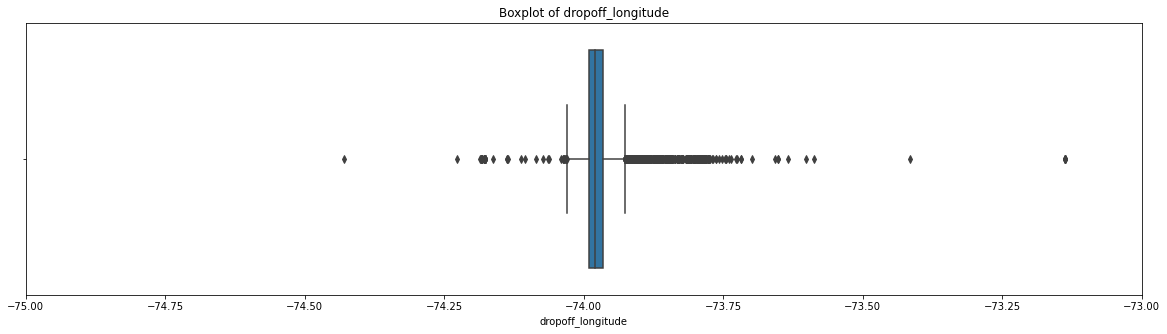

In [147]:
plt.figure(figsize=(20,5)) 
plt.xlim(-75,-73)
sns.boxplot(x=df_3['dropoff_longitude'],data=df_3,orient='h')
plt.title('Boxplot of dropoff_longitude')
plt.show()

In [148]:
q75,q25=np.percentile(df_3.loc[:,"dropoff_longitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -74.03036654749998 max: -73.92637108750002


In [149]:
df_3[(df_3['dropoff_longitude']>max) | (df_3['dropoff_longitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21+00:00,NaN,40.721319,-73.841610,40.712278,1,4.50
52,2010-05-31 18:06:00+00:00,-73.985427,40.758853,-73.872907,40.774497,1,34.67
72,2011-08-12 04:20:00+00:00,-74.006662,40.731210,-73.925940,40.825588,1,24.90
100,2009-03-25 00:08:52+00:00,NaN,40.747320,-74.035839,40.747320,1,52.00
118,2012-08-19 19:56:34+00:00,NaN,40.773748,-73.808317,40.700300,1,17.70
...,...,...,...,...,...,...,...
15630,2015-04-05 10:39:11+00:00,-73.978905,40.783115,-73.871956,40.772133,2,33.50
15633,2015-04-15 21:02:56+00:00,-74.004700,40.741741,-73.808159,40.757359,2,47.04
15660,2009-09-13 01:07:20+00:00,-73.975717,40.795568,-73.922822,40.866558,2,16.10
15664,2010-05-28 02:58:00+00:00,NaN,40.756573,-73.815065,40.705340,3,30.50


In [150]:
df_3.loc[(df_3['dropoff_longitude']>max) | (df_3['dropoff_longitude']<min),'dropoff_longitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

### 3.3.4 case 4

In [151]:
df_4['dropoff_longitude'].describe()

count    15716.000000
mean       -73.897143
std          2.831607
min        -74.429332
25%        -73.991368
50%        -73.980563
75%        -73.965369
max         40.802437
Name: dropoff_longitude, dtype: float64

In [152]:
df_4[(df_4['dropoff_longitude']>-73.137)].sort_values('dropoff_longitude',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
9339,2013-07-13 12:31:00+00:00,NaN,NaN,40.802437,-73.950730,1,15.5
8255,2013-05-24 00:32:00+00:00,NaN,NaN,40.763367,-73.961550,1,15.0
2084,2013-05-24 14:54:00+00:00,NaN,NaN,40.758867,-73.978353,2,5.0
6550,2013-05-22 15:33:00+00:00,NaN,NaN,40.757417,-73.977962,2,13.0
4663,2013-05-22 06:28:00+00:00,NaN,NaN,40.740372,-73.979010,1,6.5
7353,2013-05-22 10:54:00+00:00,NaN,NaN,40.740367,-73.994392,1,13.0
9869,2013-05-22 20:15:00+00:00,NaN,NaN,40.736887,-74.006377,6,52.0
3728,2013-06-20 04:28:00+00:00,NaN,NaN,40.723305,-73.939430,1,11.0
1141,2012-10-11 00:21:00+00:00,NaN,NaN,0.016852,0.017980,2,25.0
2216,2011-08-29 08:24:00+00:00,-73.936667,40.757815,0.000000,40.757815,1,8.9


#### By seeing the observation , dropoff_longitude >-73.137 is set as outlier

In [153]:
df_4.loc[(df_4['dropoff_longitude']>-73.137),'dropoff_longitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

## 3.4 dropoff_latitude

### 3.4.1 case 1

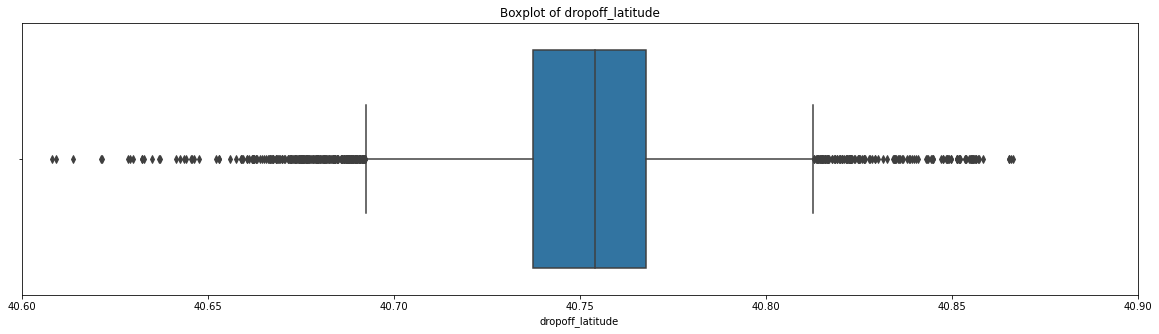

In [154]:
plt.figure(figsize=(20,5)) 
plt.xlim(40.6,40.9)
sns.boxplot(x=df_1['dropoff_latitude'],data=df_1,orient='h')
plt.title('Boxplot of dropoff_latitude')
plt.show()

In [155]:
q75,q25=np.percentile(df_1.loc[:,"dropoff_latitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: 40.69240849500001 max: 40.812931175


In [156]:
df_1[(df_1['dropoff_latitude']>max) | (df_1['dropoff_latitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
26,2011-09-07 23:05:44+00:00,-73.993717,40.740785,-73.999272,40.676617,1,18.1
27,2015-01-11 03:15:38+00:00,-73.983330,40.738720,-73.933197,40.847225,1,58.0
46,2013-11-10 01:12:19+00:00,-73.974497,40.751603,-73.934927,40.851567,4,25.5
98,2010-03-27 02:26:39+00:00,-73.961598,40.716487,-73.960417,40.674963,2,14.5
120,2010-08-24 01:39:26+00:00,-74.003848,40.720855,-73.980980,40.668304,1,12.5
...,...,...,...,...,...,...,...
13736,2010-11-16 22:43:00+00:00,-73.976240,40.761445,-73.963042,40.688533,2,19.3
13766,2013-11-06 21:08:00+00:00,-73.983790,40.741055,-73.984917,40.687787,4,20.0
13768,2014-02-09 14:37:00+00:00,-73.975885,40.787825,-73.950372,40.671797,2,26.5
13781,2009-07-30 21:35:12+00:00,-73.980865,40.760029,-73.994966,40.684292,1,21.3


In [157]:
index=df_1[(df_1['dropoff_latitude']>max) | (df_1['dropoff_latitude']<min)].index
index

Int64Index([   26,    27,    46,    98,   120,   130,   140,   199,   219,
              220,
            ...
            13653, 13685, 13703, 13711, 13715, 13736, 13766, 13768, 13781,
            13794],
           dtype='int64', length=405)

In [158]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (13859, 7) 

Shape of dataset after dropping: (13454, 7)


### 3.4.2 case 2

In [159]:
df_2['dropoff_latitude'].describe()

count    15574.000000
mean        40.748841
std          0.323157
min          0.728087
25%         40.736332
50%         40.754242
75%         40.768332
max         41.366138
Name: dropoff_latitude, dtype: float64

In [160]:
df_2[df_2['dropoff_latitude']<39.6].sort_values('dropoff_latitude')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6761,2011-06-18 04:03:00+00:00,-73.98898,40.721697,-74.001073,0.728087,3,4.5


#### By seeing the observation , dropoff_latitude <39.6 is set as outlier

In [161]:
index=df_2[df_2['dropoff_latitude']<39.6].index
index

Int64Index([6761], dtype='int64')

In [162]:
df_2=drop(df_2,index,0)

Shape of dataset before dropping: (15574, 7) 

Shape of dataset after dropping: (15573, 7)


### 3.4.3 case 3

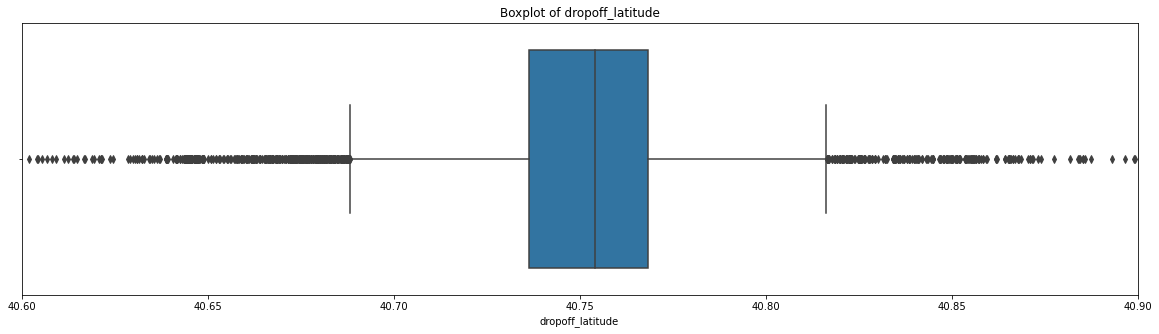

In [163]:
plt.figure(figsize=(20,5)) 
plt.xlim(40.6,40.9)
sns.boxplot(x=df_3['dropoff_latitude'],data=df_3,orient='h')
plt.title('Boxplot of dropoff_latitude')
plt.show()

In [164]:
q75,q25=np.percentile(df_3.loc[:,"dropoff_latitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: 40.688265875000006 max: 40.81633287499999


In [165]:
df_3[(df_3['dropoff_latitude']>max) | (df_3['dropoff_latitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
27,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,40.660366,1,22.54
30,2011-09-07 23:05:44+00:00,-73.993717,40.740785,-73.999272,40.676617,1,18.10
31,2015-01-11 03:15:38+00:00,-73.983330,40.738720,-73.933197,40.847225,1,58.00
50,2013-11-10 01:12:19+00:00,-73.974497,40.751603,-73.934927,40.851567,4,25.50
72,2011-08-12 04:20:00+00:00,-74.006662,40.731210,NaN,40.825588,1,24.90
...,...,...,...,...,...,...,...
15612,2013-11-06 21:08:00+00:00,-73.983790,40.741055,-73.984917,40.687787,4,20.00
15614,2014-02-09 14:37:00+00:00,-73.975885,40.787825,-73.950372,40.671797,2,26.50
15617,2010-05-11 00:10:42+00:00,NaN,40.770229,-73.932235,40.650819,1,33.30
15631,2009-07-30 21:35:12+00:00,-73.980865,40.760029,-73.994966,40.684292,1,21.30


In [166]:
df_3.loc[(df_3['dropoff_latitude']>max) | (df_3['dropoff_latitude']<min),'dropoff_latitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

### 3.4.4 case 4

In [167]:
df_4['dropoff_latitude'].describe()

count    15716.000000
mean        40.687861
std          2.627792
min        -74.006377
25%         40.736291
50%         40.754220
75%         40.768308
max         41.366138
Name: dropoff_latitude, dtype: float64

In [168]:
df_4[df_4['dropoff_latitude']<39.6].sort_values('dropoff_latitude')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
9869,2013-05-22 20:15:00+00:00,NaN,NaN,NaN,-74.006377,6,52.0
7353,2013-05-22 10:54:00+00:00,NaN,NaN,NaN,-73.994392,1,13.0
4663,2013-05-22 06:28:00+00:00,NaN,NaN,NaN,-73.979010,1,6.5
2084,2013-05-24 14:54:00+00:00,NaN,NaN,NaN,-73.978353,2,5.0
6550,2013-05-22 15:33:00+00:00,NaN,NaN,NaN,-73.977962,2,13.0
8255,2013-05-24 00:32:00+00:00,NaN,NaN,NaN,-73.961550,1,15.0
9339,2013-07-13 12:31:00+00:00,NaN,NaN,NaN,-73.950730,1,15.5
3728,2013-06-20 04:28:00+00:00,NaN,NaN,NaN,-73.939430,1,11.0
1141,2012-10-11 00:21:00+00:00,NaN,NaN,NaN,0.017980,2,25.0
6852,2011-06-18 04:03:00+00:00,-73.98898,40.721697,-74.001073,0.728087,3,4.5


#### By seeing the observation , dropoff_latitude <39.6 is set as outlier

In [169]:
df_4.loc[df_4['dropoff_latitude']<39.6,'dropoff_latitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

## 3.5 fare_amount

#### Since fare_amount is the target variable, we will be directly dropping the outliers instead of setting to NaN 

### 3.5.1 case 1

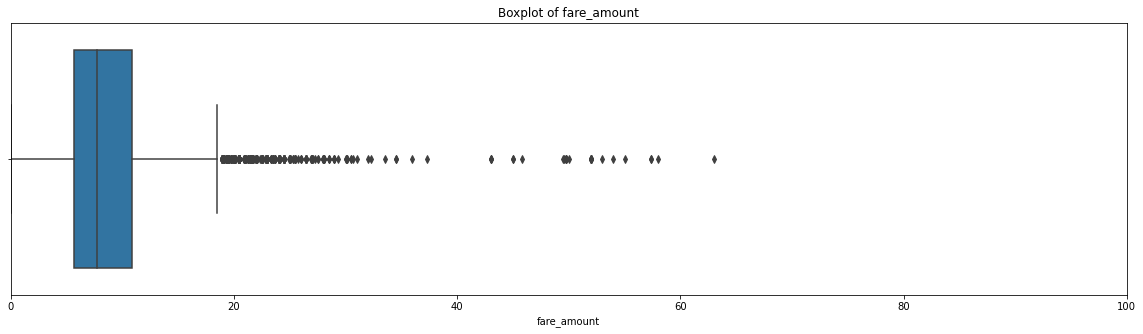

In [170]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=df_1['fare_amount'],data=df_1,orient='h')
plt.title('Boxplot of fare_amount')
plt.show()

In [171]:
q75,q25=np.percentile(df_1.loc[:,"fare_amount"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -2.1000000000000005 max: 18.700000000000003


In [172]:
df_1[(df_1['fare_amount']>max) | (df_1['fare_amount']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
148,2014-07-12 15:22:00+00:00,-74.012780,40.707952,-73.997932,40.760632,6,24.5
152,2013-05-02 07:41:00+00:00,-73.987285,40.718622,-73.959295,40.778482,1,27.0
243,2014-08-21 10:21:17+00:00,-73.974020,40.762828,-73.940839,40.726467,1,19.0
255,2011-12-05 08:38:34+00:00,-73.968619,40.766432,-74.008559,40.704591,1,20.5
261,2010-02-27 20:13:00+00:00,-73.977765,40.766177,-73.977982,40.766937,5,26.5
...,...,...,...,...,...,...,...
13306,2014-03-17 12:12:00+00:00,-74.013310,40.708689,-73.980225,40.761226,1,22.0
13339,2013-05-10 01:30:41+00:00,-74.006340,40.733718,-73.959535,40.730950,2,23.0
13340,2009-01-06 09:29:00+00:00,-74.015903,40.711410,-73.954777,40.765363,1,19.3
13342,2015-05-07 18:44:17+00:00,-74.008736,40.712700,-73.977959,40.766418,1,24.0


In [173]:
index=df_1[(df_1['fare_amount']>max) | (df_1['fare_amount']<min)].index
index

Int64Index([  148,   152,   243,   255,   261,   267,   273,   294,   319,
              330,
            ...
            13237, 13238, 13264, 13273, 13302, 13306, 13339, 13340, 13342,
            13448],
           dtype='int64', length=519)

In [174]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (13454, 7) 

Shape of dataset after dropping: (12935, 7)


### 3.5.2 case 2

In [175]:
df_2['fare_amount'].describe()

count    15573.000000
mean        15.159538
std        436.903326
min          0.010000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

In [176]:
df_2[df_2['fare_amount']>180].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
935,2015-02-27 17:03:50+00:00,-74.003319,40.727455,-73.964470,40.764378,1,54343.0
991,2012-01-15 20:42:04+00:00,-73.976309,40.751634,-74.014854,40.709044,1,4343.0
555,2011-03-03 07:40:59+00:00,-74.007816,40.733536,-73.986556,40.740040,1,453.0
901,2011-10-24 22:54:00+00:00,-73.990602,40.761100,-73.960025,40.779580,2,434.0
1041,2009-09-22 19:01:01+00:00,-73.979610,40.771326,-73.975764,40.781965,1,430.0


#### By seeing the observation , fare_amount >180 is set as outlier

In [177]:
index=df_2[df_2['fare_amount']>180].index
index

Int64Index([555, 901, 935, 991, 1041], dtype='int64')

In [178]:
df_2=drop(df_2,index,0)

Shape of dataset before dropping: (15573, 7) 

Shape of dataset after dropping: (15568, 7)


### 3.5.3 case 3

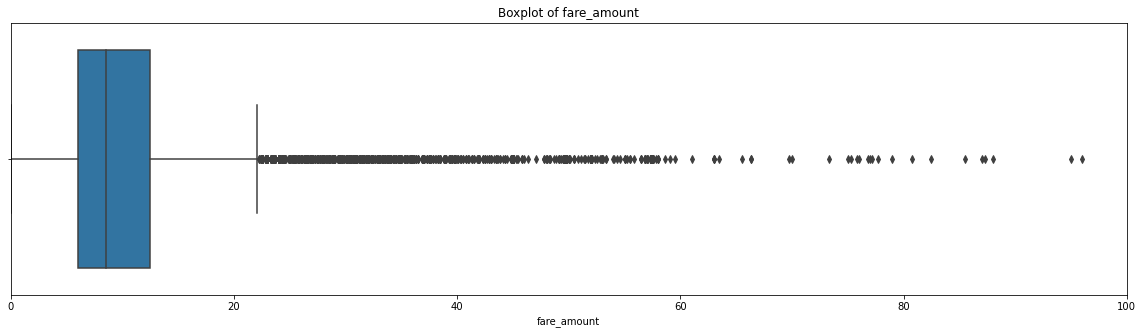

In [179]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=df_3['fare_amount'],data=df_3,orient='h')
plt.title('Boxplot of fare_amount')
plt.show()

In [180]:
q75,q25=np.percentile(df_3.loc[:,"fare_amount"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -3.75 max: 22.25


In [181]:
df_3[(df_3['fare_amount']>max) | (df_3['fare_amount']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
27,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,NaN,1,22.54
28,2009-01-09 16:10:00+00:00,NaN,40.773883,-73.984545,40.769545,3,31.90
31,2015-01-11 03:15:38+00:00,-73.983330,40.738720,-73.933197,NaN,1,58.00
50,2013-11-10 01:12:19+00:00,-73.974497,40.751603,-73.934927,NaN,4,25.50
52,2010-05-31 18:06:00+00:00,-73.985427,40.758853,NaN,40.774497,1,34.67
...,...,...,...,...,...,...,...
15633,2015-04-15 21:02:56+00:00,-74.004700,40.741741,NaN,40.757359,2,47.04
15634,2009-08-25 21:53:00+00:00,NaN,40.772007,-73.981828,40.781113,1,25.30
15664,2010-05-28 02:58:00+00:00,NaN,40.756573,NaN,40.705340,3,30.50
15673,2013-09-10 19:03:00+00:00,NaN,NaN,-73.982160,40.761590,2,57.33


In [182]:
index=df_3[(df_3['fare_amount']>max) | (df_3['fare_amount']<min)].index
index

Int64Index([   27,    28,    31,    50,    52,    72,   100,   107,   113,
              125,
            ...
            15614, 15617, 15624, 15626, 15630, 15633, 15634, 15664, 15673,
            15705],
           dtype='int64', length=1362)

In [183]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (15716, 7) 

Shape of dataset after dropping: (14354, 7)


### 3.5.4 case 4

In [184]:
df_4['fare_amount'].describe()

count    15716.000000
mean        15.113220
std        434.911842
min          0.010000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

In [185]:
df_4[df_4['fare_amount']>180].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
975,2015-02-27 17:03:50+00:00,-74.003319,40.727455,-73.964470,40.764378,1,54343.0
1032,2012-01-15 20:42:04+00:00,-73.976309,40.751634,-74.014854,40.709044,1,4343.0
583,2011-03-03 07:40:59+00:00,-74.007816,40.733536,-73.986556,40.740040,1,453.0
940,2011-10-24 22:54:00+00:00,-73.990602,40.761100,-73.960025,40.779580,2,434.0
1083,2009-09-22 19:01:01+00:00,-73.979610,40.771326,-73.975764,40.781965,1,430.0


#### By seeing the observation , fare_amount >180 is set as outlier

In [186]:
index=df_4[df_4['fare_amount']>180].index
index

Int64Index([583, 940, 975, 1032, 1083], dtype='int64')

In [187]:
df_4=drop(df_4,index,0)

Shape of dataset before dropping: (15716, 7) 

Shape of dataset after dropping: (15711, 7)


## 3.6 Imputation of missing values of outliers

### 3.6.1 case 3

#### Checking whether pickup_longitude and pickup_latitude = NaN or dropoff_longitude and dropoff_latitude = NaN
#### If found drop them

In [188]:
df_3[(df_3['pickup_longitude'].isna() & df_3['pickup_latitude'].isna()) | (df_3['dropoff_longitude'].isna() & df_3['dropoff_latitude'].isna())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
220,2010-05-28 21:33:07+00:00,NaN,NaN,NaN,NaN,1,16.1
531,2013-10-05 20:24:51+00:00,NaN,NaN,NaN,NaN,1,16.0
582,2013-04-12 19:57:22+00:00,NaN,NaN,-73.996509,40.737216,1,5.5
635,2010-06-15 01:06:00+00:00,NaN,NaN,NaN,NaN,1,8.9
914,2011-03-24 22:20:12+00:00,-73.940342,40.800480,NaN,NaN,1,14.9
...,...,...,...,...,...,...,...
13893,2010-08-09 06:07:10+00:00,NaN,NaN,-74.006270,40.708667,1,13.7
14040,2009-10-03 18:06:46+00:00,NaN,NaN,NaN,40.712621,1,19.3
14158,2013-04-05 20:40:00+00:00,-73.991130,40.700835,NaN,NaN,2,20.5
14214,2011-11-20 12:58:00+00:00,NaN,NaN,-73.928838,NaN,2,12.5


In [189]:
index=df_3[(df_3['pickup_longitude'].isna() & df_3['pickup_latitude'].isna()) | (df_3['dropoff_longitude'].isna() & df_3['dropoff_latitude'].isna())].index
index

Int64Index([  220,   531,   582,   635,   914,   975,   993,  1351,  1452,
             1472,
            ...
            13186, 13610, 13631, 13776, 13841, 13893, 14040, 14158, 14214,
            14301],
           dtype='int64', length=110)

In [190]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (14354, 7) 

Shape of dataset after dropping: (14244, 7)


In [191]:
pd.DataFrame(pd.concat([df_3.isnull().sum(),df_3.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
dropoff_latitude,303,2.127211
dropoff_longitude,268,1.881494
pickup_longitude,205,1.439202
pickup_latitude,175,1.228587
pickup_datetime,0,0.000000
passenger_count,0,0.000000
fare_amount,0,0.000000


#### Here we are using KNN imputation for missing value imputation

In [192]:
df_3_testing=pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df_3.iloc[:,1:]),columns=df_3.columns[1:])

In [193]:
df_3=pd.concat([df_3.iloc[:,0],df_3_testing],axis=1)

In [194]:
df_3['passenger_count']=pd.to_numeric(df_3['passenger_count']).astype('int64')

In [195]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14244 entries, 0 to 14243
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    14244 non-null  datetime64[ns, UTC]
 1   pickup_longitude   14244 non-null  float64            
 2   pickup_latitude    14244 non-null  float64            
 3   dropoff_longitude  14244 non-null  float64            
 4   dropoff_latitude   14244 non-null  float64            
 5   passenger_count    14244 non-null  int64              
 6   fare_amount        14244 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 779.1 KB


In [196]:
df_3.isna().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

### 3.6.2 case 4

#### Checking whether pickup_longitude and pickup_latitude = NaN or dropoff_longitude and dropoff_latitude = NaN
#### If found drop them

In [197]:
df_4[(df_4['pickup_longitude'].isna() & df_4['pickup_latitude'].isna()) | (df_4['dropoff_longitude'].isna() & df_4['dropoff_latitude'].isna())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1136,2012-10-11 00:21:00+00:00,NaN,NaN,NaN,NaN,2,25.0
2079,2013-05-24 14:54:00+00:00,NaN,NaN,NaN,NaN,2,5.0
3723,2013-06-20 04:28:00+00:00,NaN,NaN,NaN,NaN,1,11.0
4658,2013-05-22 06:28:00+00:00,NaN,NaN,NaN,NaN,1,6.5
6545,2013-05-22 15:33:00+00:00,NaN,NaN,NaN,NaN,2,13.0
7348,2013-05-22 10:54:00+00:00,NaN,NaN,NaN,NaN,1,13.0
8250,2013-05-24 00:32:00+00:00,NaN,NaN,NaN,NaN,1,15.0
9334,2013-07-13 12:31:00+00:00,NaN,NaN,NaN,NaN,1,15.5
9864,2013-05-22 20:15:00+00:00,NaN,NaN,NaN,NaN,6,52.0


In [198]:
index=df_4[(df_4['pickup_longitude'].isna() & df_4['pickup_latitude'].isna()) | (df_4['dropoff_longitude'].isna() & df_4['dropoff_latitude'].isna())].index
index

Int64Index([1136, 2079, 3723, 4658, 6545, 7348, 8250, 9334, 9864], dtype='int64')

In [199]:
df_4=drop(df_4,index,0)

Shape of dataset before dropping: (15711, 7) 

Shape of dataset after dropping: (15702, 7)


In [200]:
pd.DataFrame(pd.concat([df_4.isnull().sum(),df_4.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
dropoff_longitude,3,0.019106
dropoff_latitude,1,0.006369
pickup_datetime,0,0.000000
pickup_longitude,0,0.000000
pickup_latitude,0,0.000000
passenger_count,0,0.000000
fare_amount,0,0.000000


#### Here we are using KNN imputation for missing value imputation

In [201]:
df_4_testing=pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df_4.iloc[:,1:]),columns=df_4.columns[1:])

In [202]:
df_4=pd.concat([df_4.iloc[:,0],df_4_testing],axis=1)

In [203]:
df_4['passenger_count']=pd.to_numeric(df_4['passenger_count']).astype('int64')

In [204]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15702 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15702 non-null  float64            
 2   pickup_latitude    15702 non-null  float64            
 3   dropoff_longitude  15702 non-null  float64            
 4   dropoff_latitude   15702 non-null  float64            
 5   passenger_count    15702 non-null  int64              
 6   fare_amount        15702 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 858.8 KB


In [205]:
df_4.isna().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

# 4.Feature Extraction

## 4.1 Using pickup_longitude, pickup_latitude, dropoff_longitude and dropoff_latitude

In [206]:
#creating a function dist to calculate the distance
def dist(df):
    dist=[]
    for i in range(len(df)):
        pickup_latitude=df.loc[i,'pickup_latitude']
        pickup_longitude=df.loc[i,'pickup_longitude']
        dropoff_latitude=df.loc[i,'dropoff_latitude']
        dropoff_longitude=df.loc[i,'dropoff_longitude']
        pickup_place = (pickup_latitude,pickup_longitude)
        dropoff_place = (dropoff_latitude,dropoff_longitude)
        dist.append(vincenty(pickup_place, dropoff_place))
    return dist

In [207]:
df_1['distance']=dist(df_1)
df_2['distance']=dist(df_2)
df_3['distance']=dist(df_3)
df_4['distance']=dist(df_4)
test['distance']=dist(test)

In [208]:
df_1['distance'].describe()

count    12935.000000
mean         2.246305
std          1.478465
min          0.000000
25%          1.165144
50%          1.876459
75%          2.970621
max          9.910799
Name: distance, dtype: float64

In [209]:
df_2['distance'].describe()

count    15568.000000
mean         3.409912
std          4.590243
min          0.000000
25%          1.257965
50%          2.170056
75%          3.898852
max        129.767395
Name: distance, dtype: float64

In [210]:
df_3['distance'].describe()

count    14244.000000
mean         2.384548
std          1.637550
min          0.000000
25%          1.193217
50%          1.945168
75%          3.164825
max         11.409653
Name: distance, dtype: float64

In [211]:
df_4['distance'].describe()

count    15702.000000
mean         3.405270
std          4.578931
min          0.000000
25%          1.257765
50%          2.169765
75%          3.896224
max        129.767395
Name: distance, dtype: float64

In [212]:
test['distance'].describe()

count    9914.000000
mean        3.436325
std         3.975529
min         0.000000
25%         1.299268
50%         2.218088
75%         4.045368
max       100.063275
Name: distance, dtype: float64

#### Since min value of distance=0 for test.csv dataset, we are not removing or setting to NaN for those observations in our train dataset.

## 4.2 Using pickup_datetime

In [213]:
a=pd.DataFrame()
a["pickup_year"] = test["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = test["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = test["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = test["pickup_datetime"].apply(lambda row: row.hour)
test=pd.concat([a,test.iloc[:,5:7]],axis=1)
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,2015,1,1,13,1,2.320991
1,2015,1,1,13,1,2.423802
2,2011,10,5,11,1,0.618182
3,2012,12,5,21,1,1.959671
4,2012,12,5,21,1,5.382833


In [214]:
test['pickup_year'].value_counts()

2011    2050
2014    1902
2010    1753
2012    1433
2013    1135
2009    1022
2015     619
Name: pickup_year, dtype: int64

In [215]:
year={2009:0,2010:1,2011:2,2012:3,2013:4,2014:5,2015:6}
test["pickup_year"] = test["pickup_year"].map(year)
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,6,1,1,13,1,2.320991
1,6,1,1,13,1,2.423802
2,2,10,5,11,1,0.618182
3,3,12,5,21,1,1.959671
4,3,12,5,21,1,5.382833


In [216]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         9914 non-null   int64  
 1   pickup_month        9914 non-null   int64  
 2   pickup_day_of_week  9914 non-null   int64  
 3   pickup_hour         9914 non-null   int64  
 4   passenger_count     9914 non-null   int64  
 5   distance            9914 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 464.8 KB


### 4.2.1 case 1

In [217]:
a=pd.DataFrame()
a["pickup_year"] = df_1["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = df_1["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = df_1["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = df_1["pickup_datetime"].apply(lambda row: row.hour)
df_1=pd.concat([a,df_1.iloc[:,[5,7,6]]],axis=1)
df_1["pickup_year"] = df_1["pickup_year"].map(year)
df_1.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,1,1,1,16,1,8.443441,16.9
1,2,8,3,0,2,1.389132,5.7
2,3,4,5,4,1,2.795790,7.7
3,1,3,1,7,1,1.998338,5.3
4,2,1,3,9,1,3.787980,12.1


In [218]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12935 entries, 0 to 12934
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         12935 non-null  int64  
 1   pickup_month        12935 non-null  int64  
 2   pickup_day_of_week  12935 non-null  int64  
 3   pickup_hour         12935 non-null  int64  
 4   passenger_count     12935 non-null  int64  
 5   distance            12935 non-null  float64
 6   fare_amount         12935 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 707.5 KB


In [219]:
df_1.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,1,1,1,16,1,8.443441,16.9
1,2,8,3,0,2,1.389132,5.7
2,3,4,5,4,1,2.795790,7.7
3,1,3,1,7,1,1.998338,5.3
4,2,1,3,9,1,3.787980,12.1


C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_year', ylabel='count'>

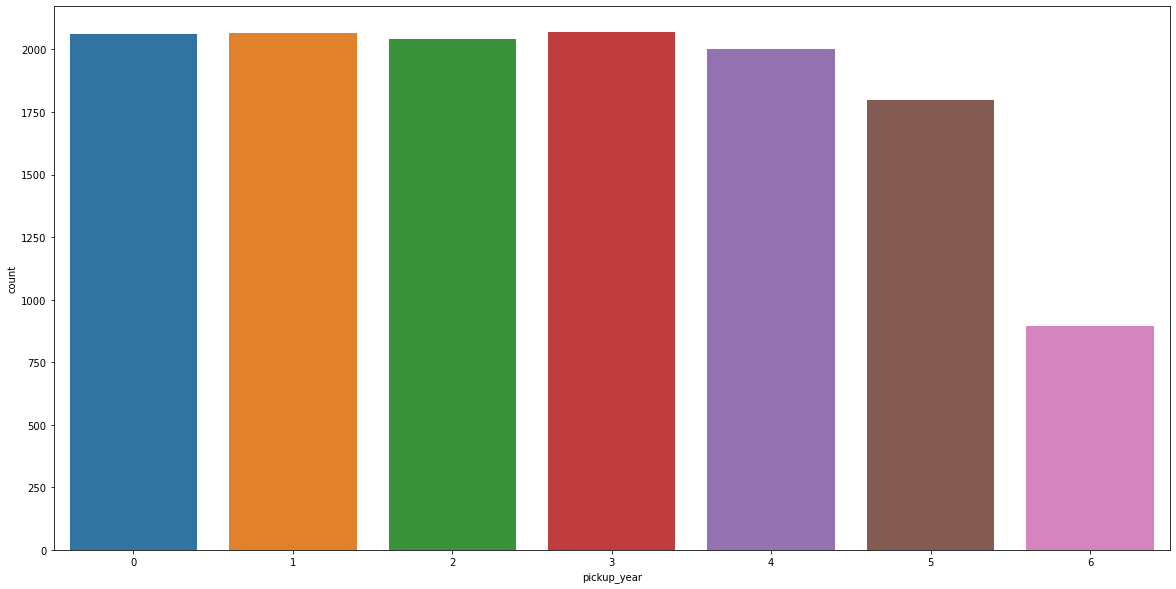

In [220]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['pickup_year'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_month', ylabel='count'>

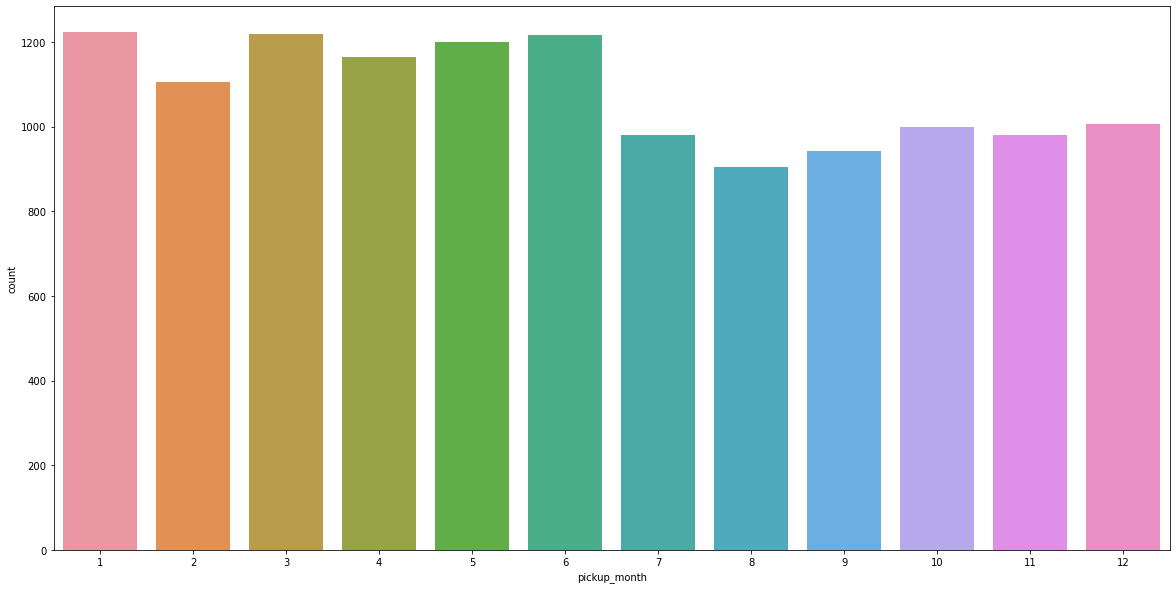

In [221]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['pickup_month'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

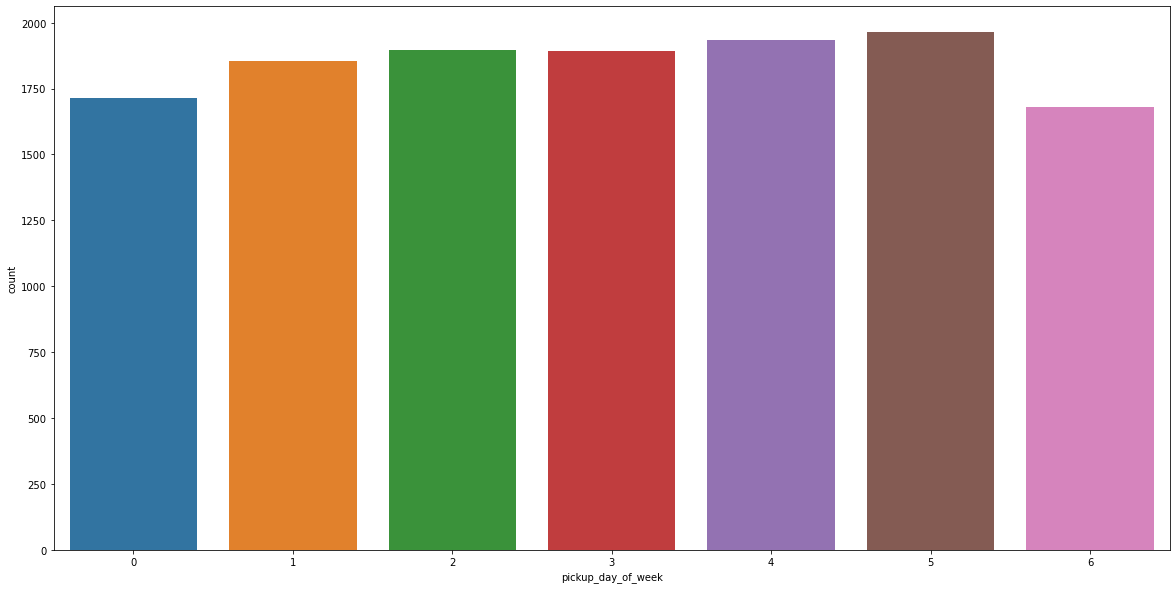

In [222]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['pickup_day_of_week'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_hour', ylabel='count'>

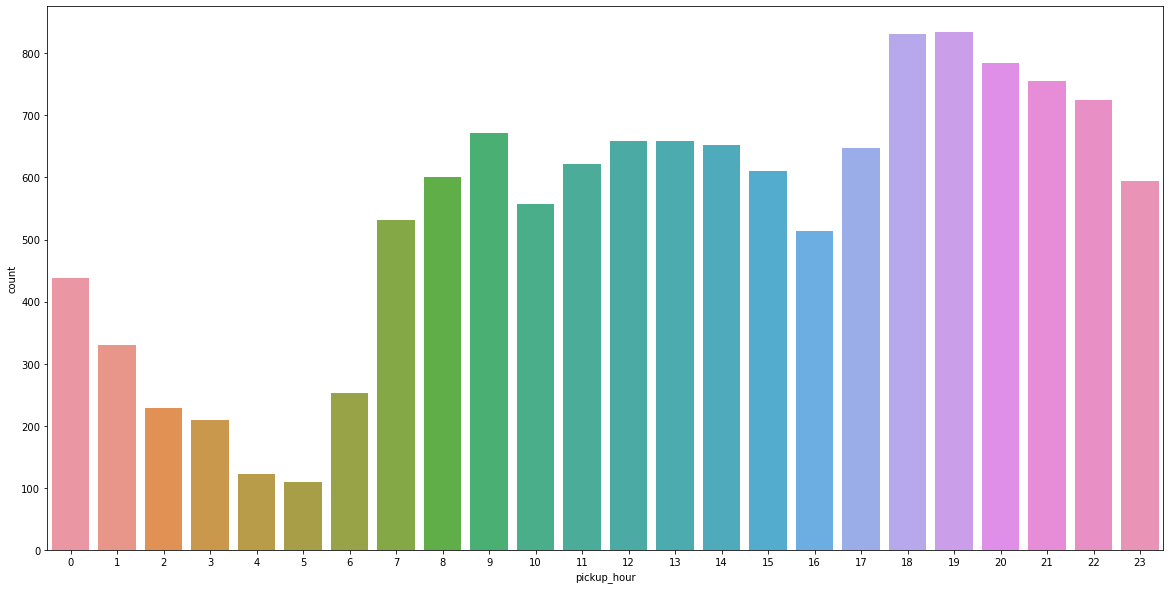

In [223]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['pickup_hour'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

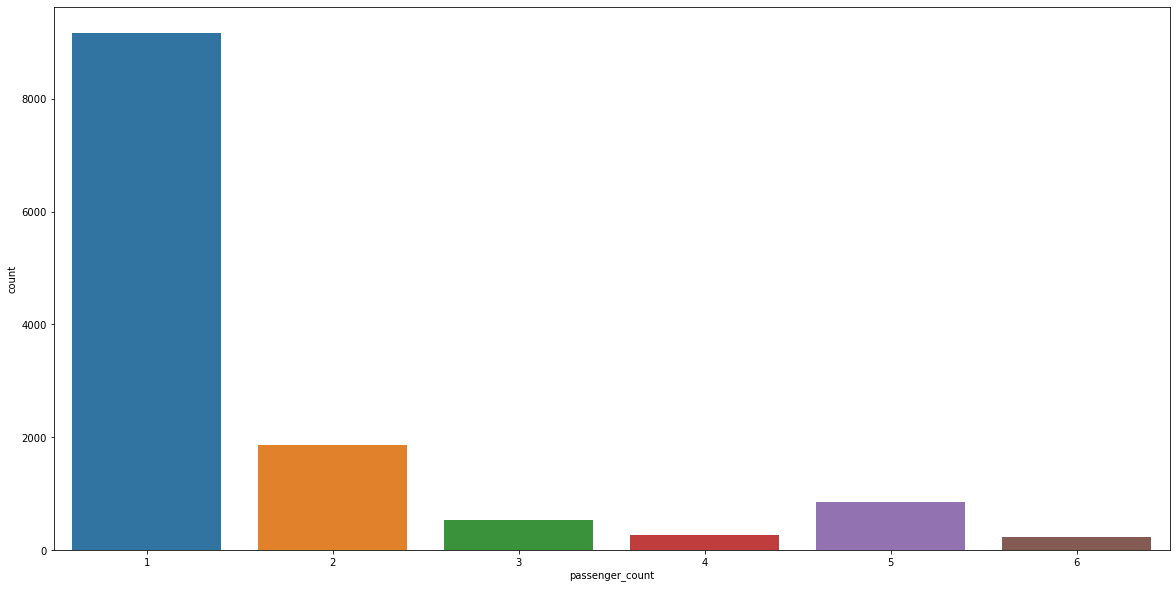

In [224]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['passenger_count'])

### 4.2.2 case 2

In [225]:
a=pd.DataFrame()
a["pickup_year"] = df_2["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = df_2["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = df_2["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = df_2["pickup_datetime"].apply(lambda row: row.hour)
df_2=pd.concat([a,df_2.iloc[:,[5,7,6]]],axis=1)
df_2["pickup_year"] = df_2["pickup_year"].map(year)
df_2.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


In [226]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15568 entries, 0 to 15567
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         15568 non-null  int64  
 1   pickup_month        15568 non-null  int64  
 2   pickup_day_of_week  15568 non-null  int64  
 3   pickup_hour         15568 non-null  int64  
 4   passenger_count     15568 non-null  int64  
 5   distance            15568 non-null  float64
 6   fare_amount         15568 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 851.5 KB


In [227]:
df_2.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_year', ylabel='count'>

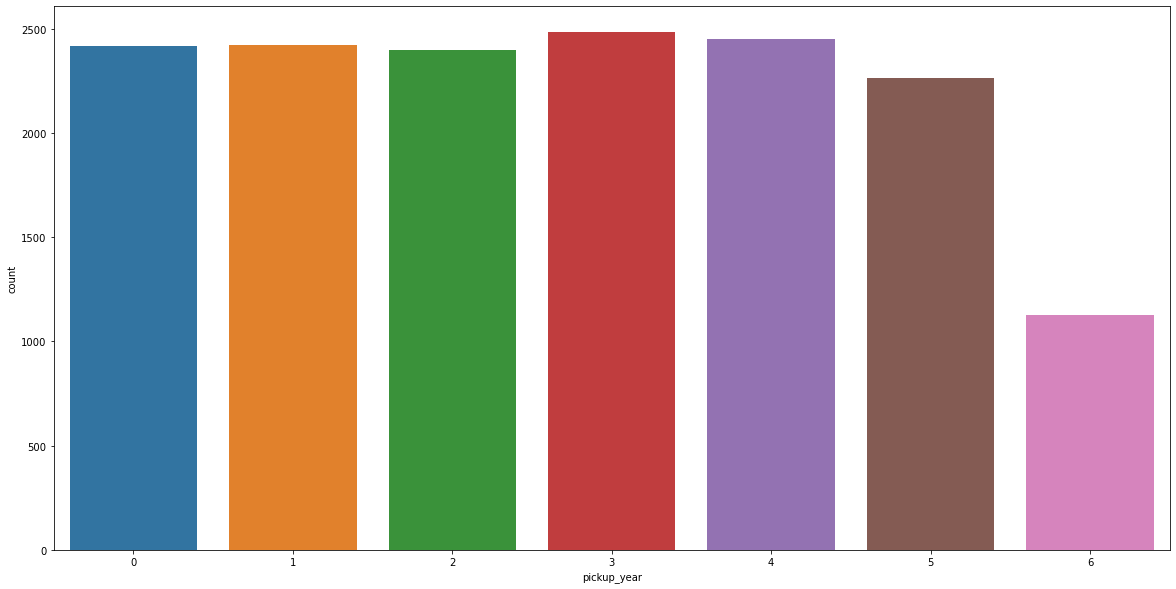

In [228]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['pickup_year'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_month', ylabel='count'>

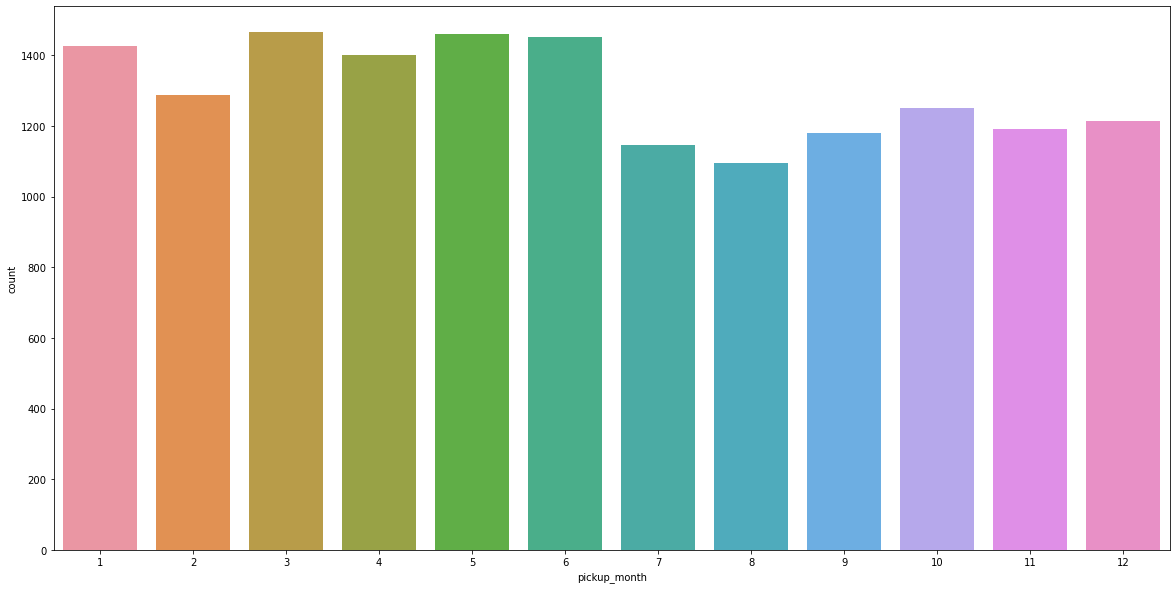

In [229]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['pickup_month'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

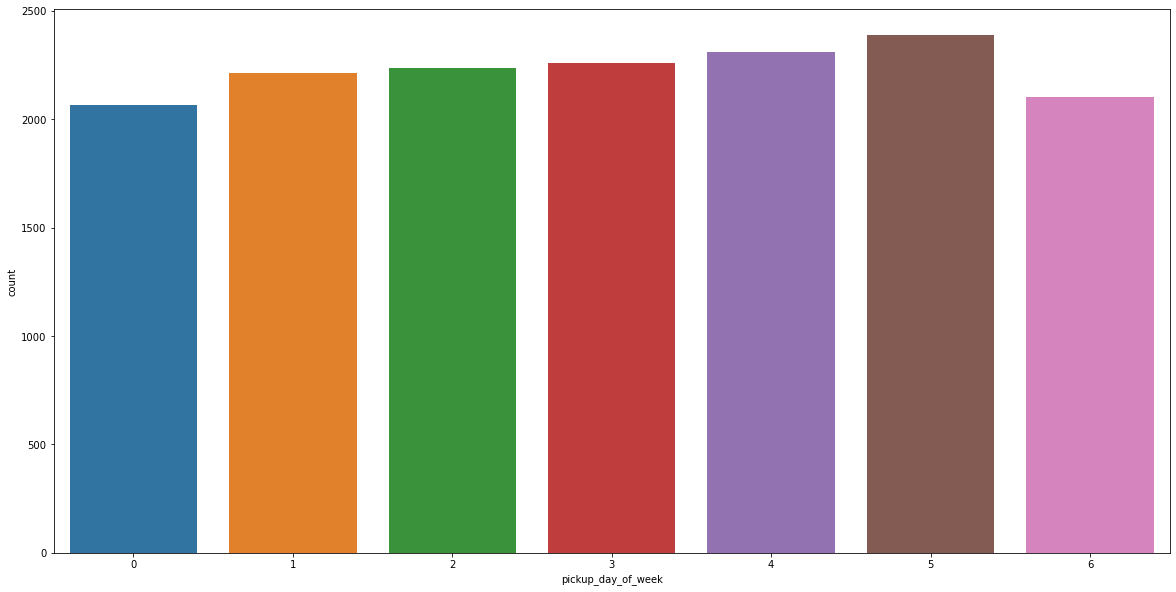

In [230]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['pickup_day_of_week'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_hour', ylabel='count'>

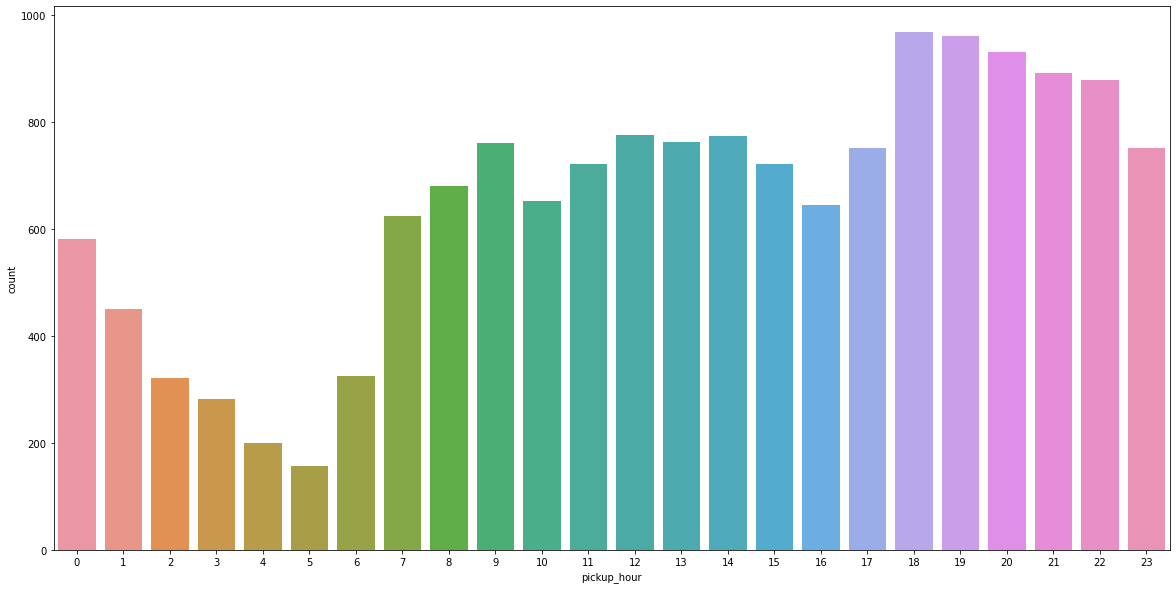

In [231]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['pickup_hour'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

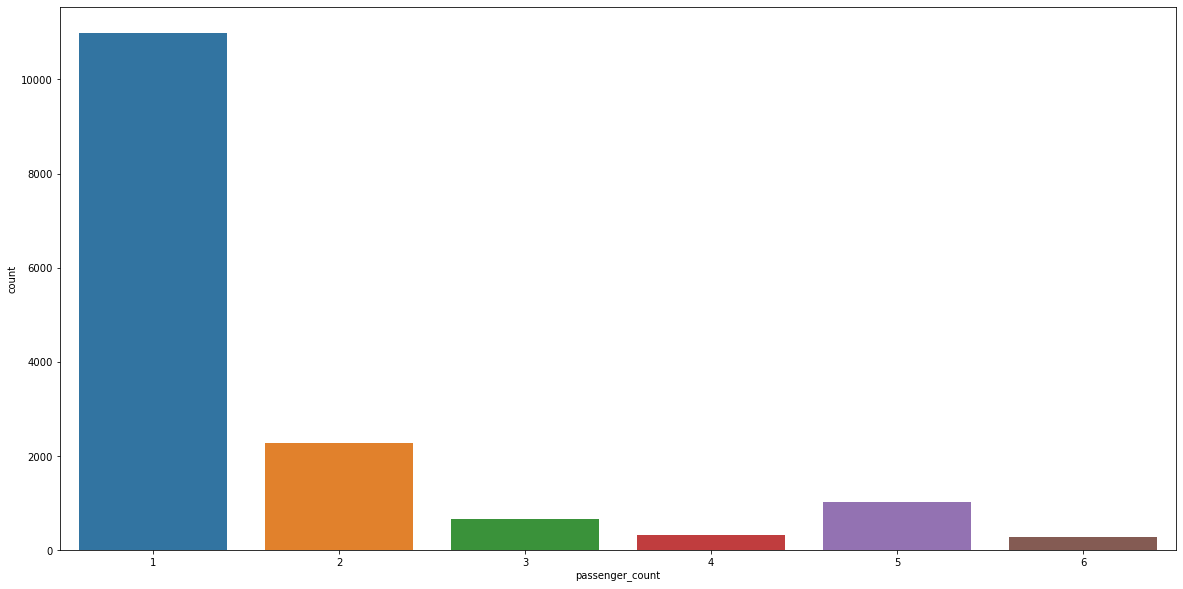

In [232]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['passenger_count'])

### 4.2.3 case 3

In [233]:
a=pd.DataFrame()
a["pickup_year"] = df_3["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = df_3["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = df_3["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = df_3["pickup_datetime"].apply(lambda row: row.hour)
df_3=pd.concat([a,df_3.iloc[:,[5,7,6]]],axis=1)
df_3["pickup_year"] = df_3["pickup_year"].map(year)
df_3.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.052860,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


In [234]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14244 entries, 0 to 14243
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         14244 non-null  int64  
 1   pickup_month        14244 non-null  int64  
 2   pickup_day_of_week  14244 non-null  int64  
 3   pickup_hour         14244 non-null  int64  
 4   passenger_count     14244 non-null  int64  
 5   distance            14244 non-null  float64
 6   fare_amount         14244 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 779.1 KB


In [235]:
df_3.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.052860,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_year', ylabel='count'>

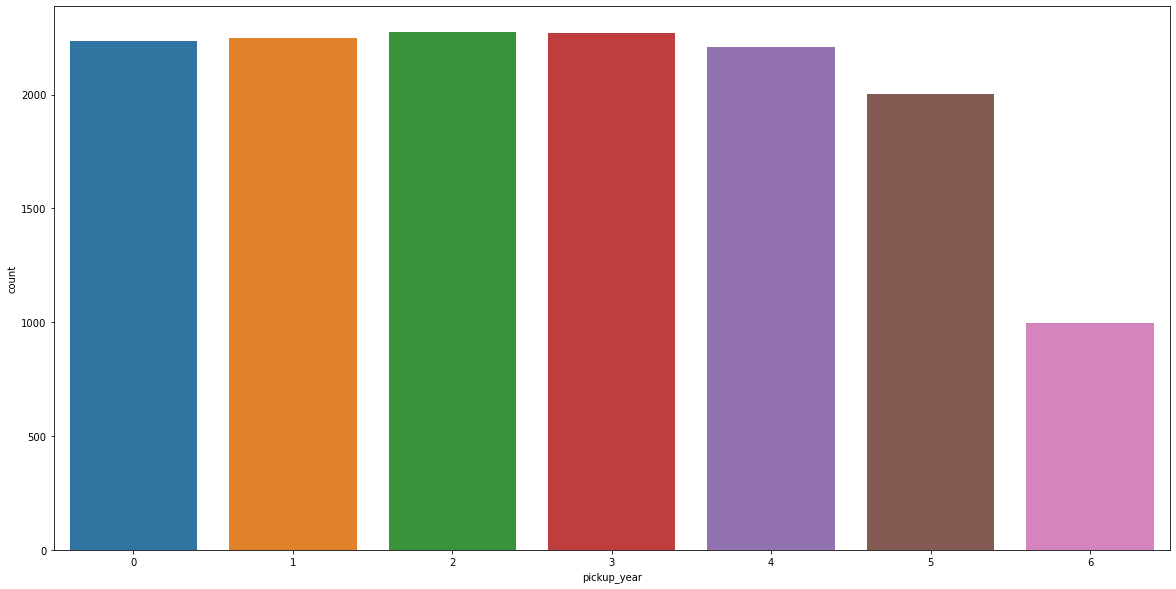

In [236]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['pickup_year'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_month', ylabel='count'>

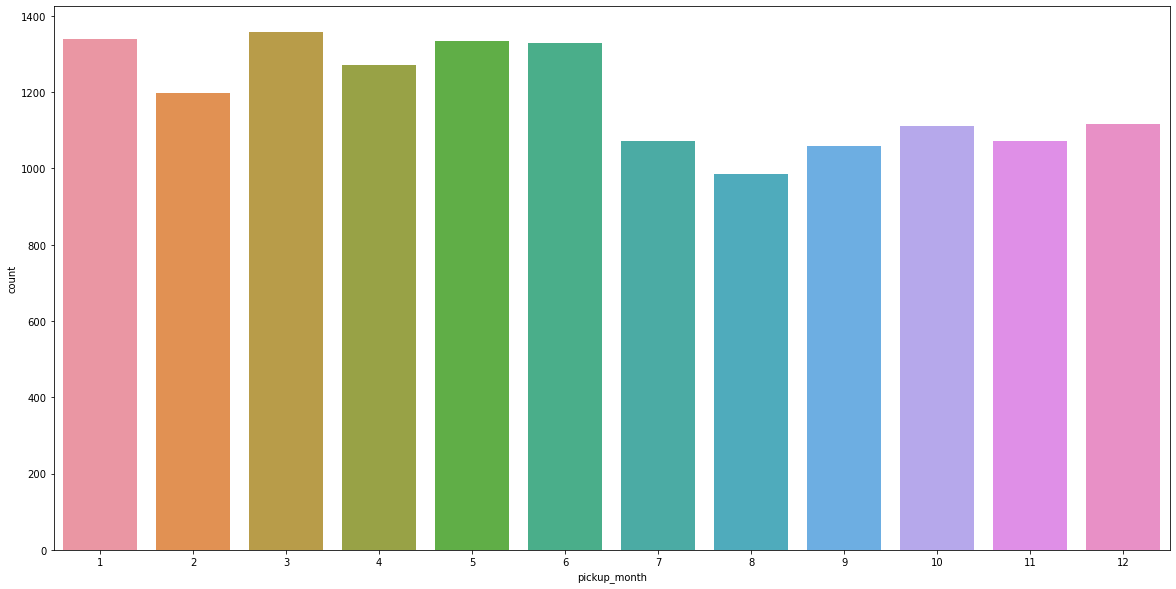

In [237]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['pickup_month'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

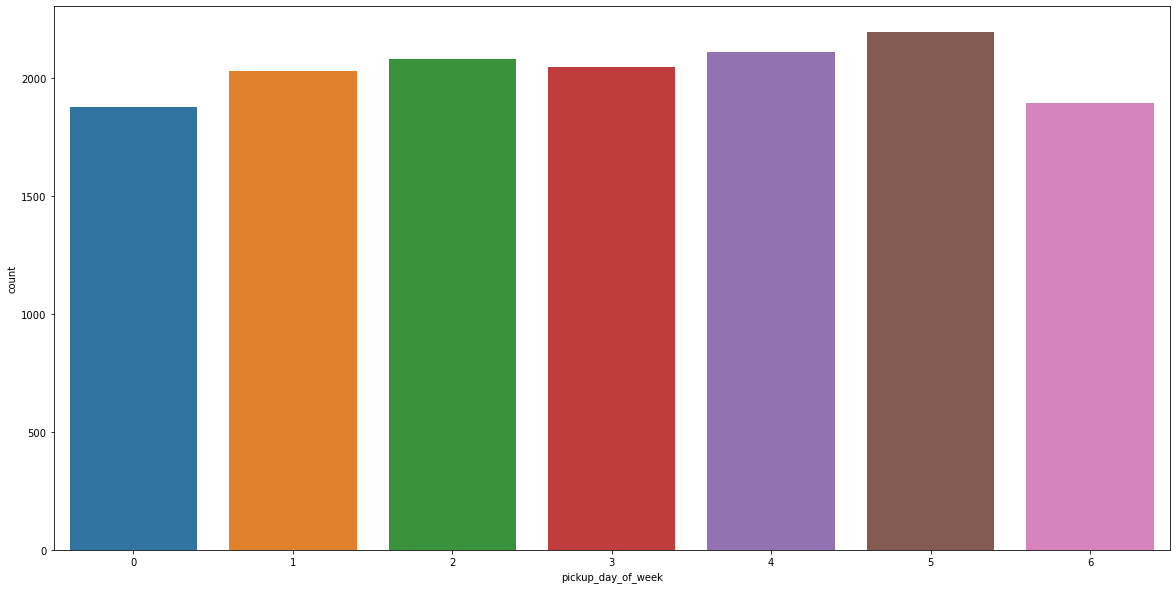

In [238]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['pickup_day_of_week'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_hour', ylabel='count'>

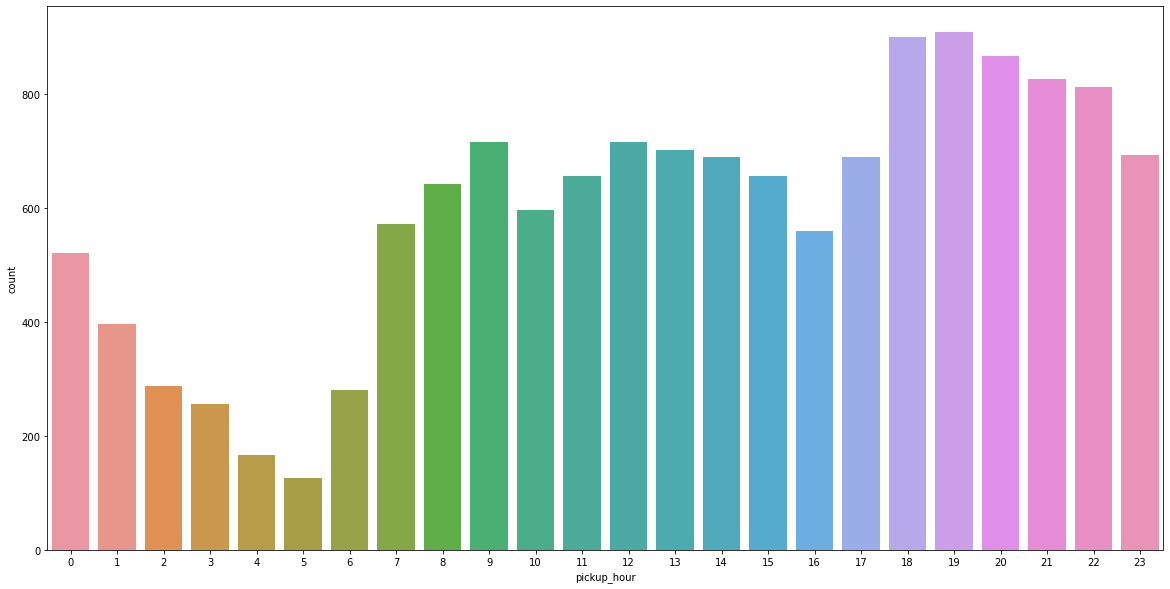

In [239]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['pickup_hour'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

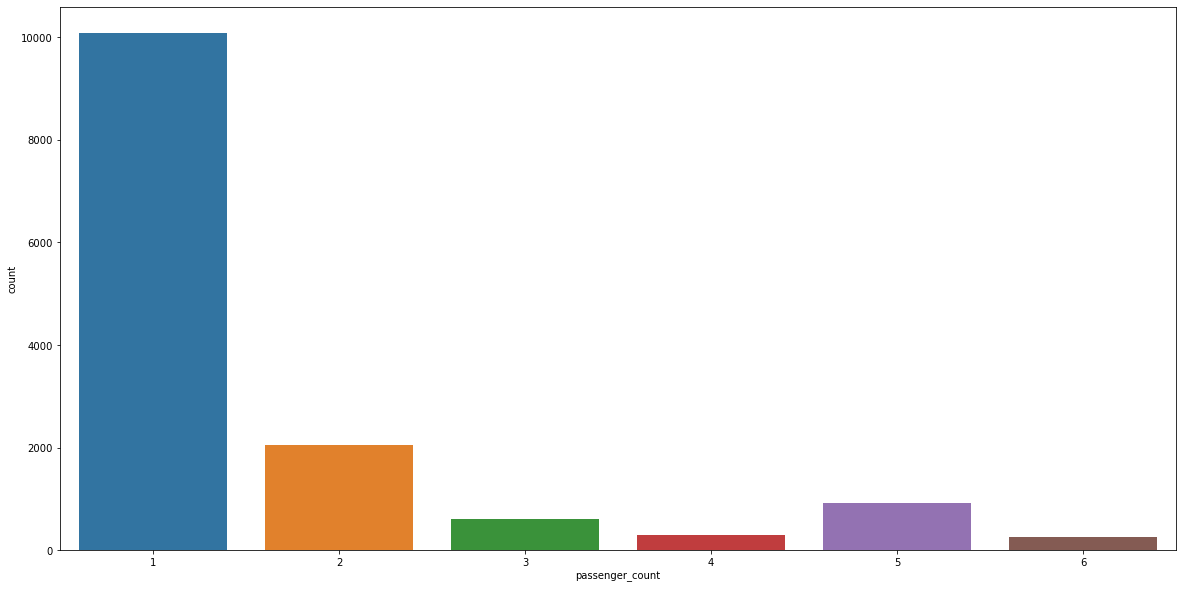

In [240]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['passenger_count'])

### 4.2.4 case 4

In [241]:
a=pd.DataFrame()
a["pickup_year"] = df_4["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = df_4["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = df_4["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = df_4["pickup_datetime"].apply(lambda row: row.hour)
df_4=pd.concat([a,df_4.iloc[:,[5,7,6]]],axis=1)
df_4["pickup_year"] = df_4["pickup_year"].map(year)
df_4.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


In [242]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         15702 non-null  int64  
 1   pickup_month        15702 non-null  int64  
 2   pickup_day_of_week  15702 non-null  int64  
 3   pickup_hour         15702 non-null  int64  
 4   passenger_count     15702 non-null  int64  
 5   distance            15702 non-null  float64
 6   fare_amount         15702 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 858.8 KB


In [243]:
df_4.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_year', ylabel='count'>

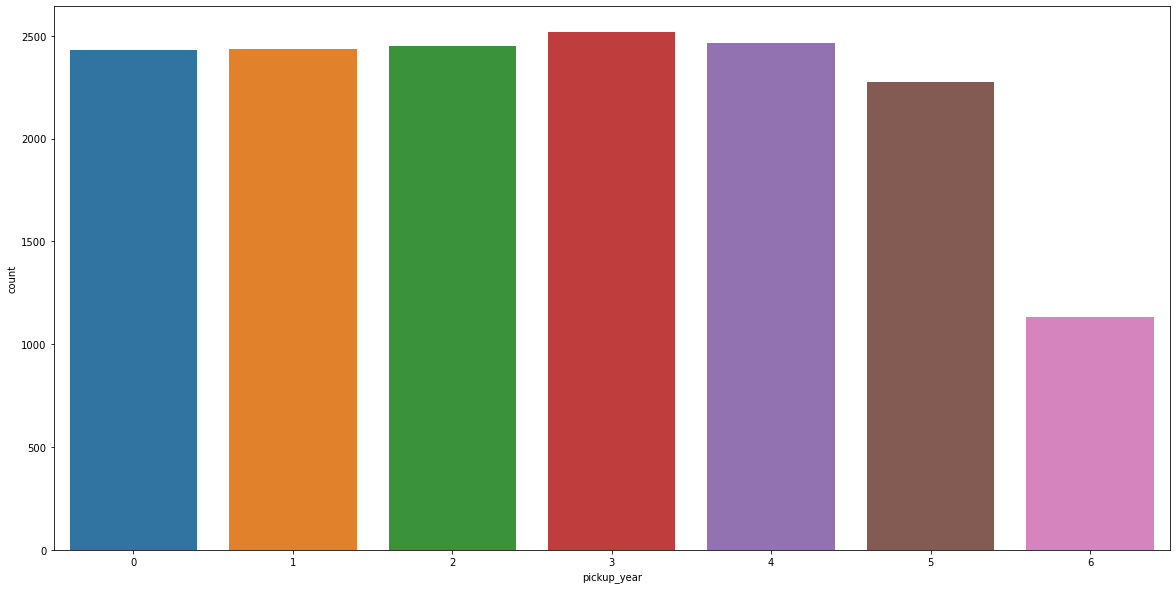

In [244]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['pickup_year'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_month', ylabel='count'>

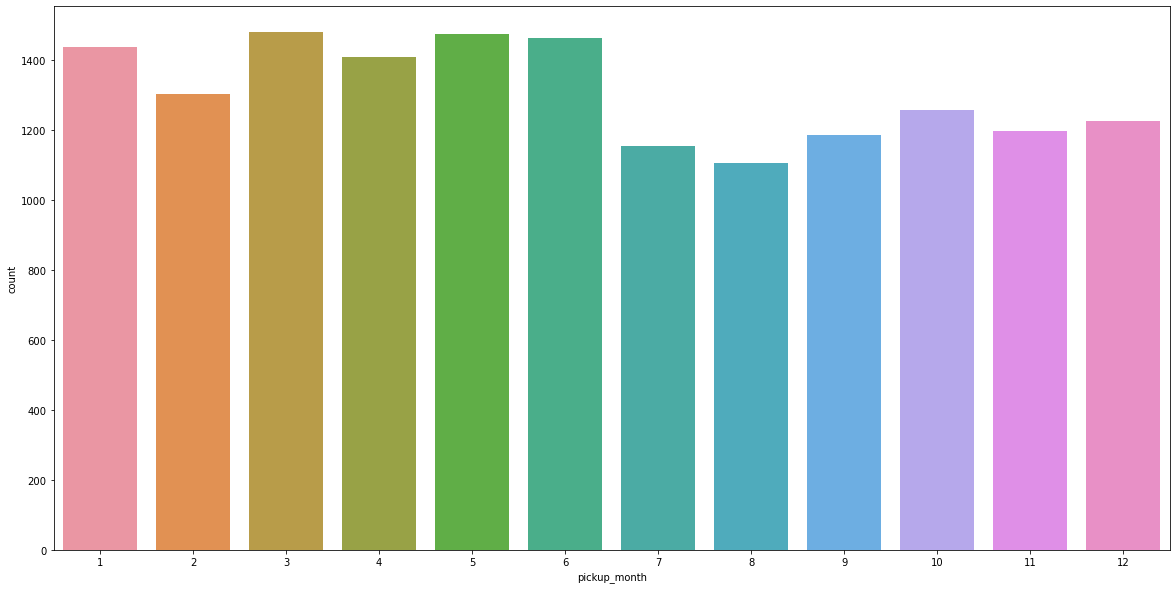

In [245]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['pickup_month'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

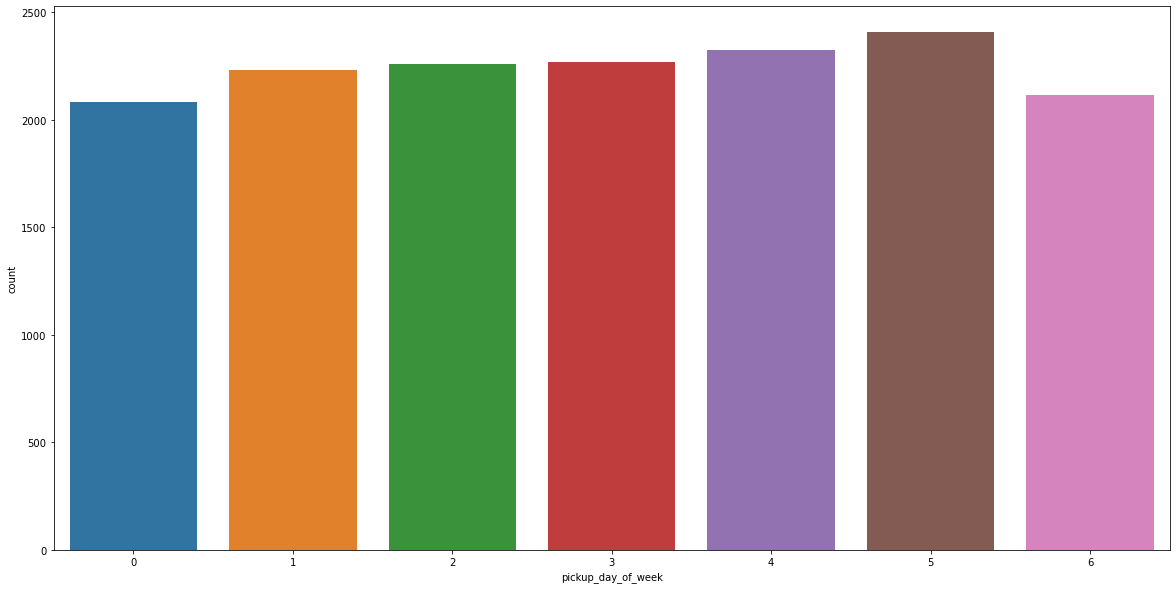

In [246]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['pickup_day_of_week'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_hour', ylabel='count'>

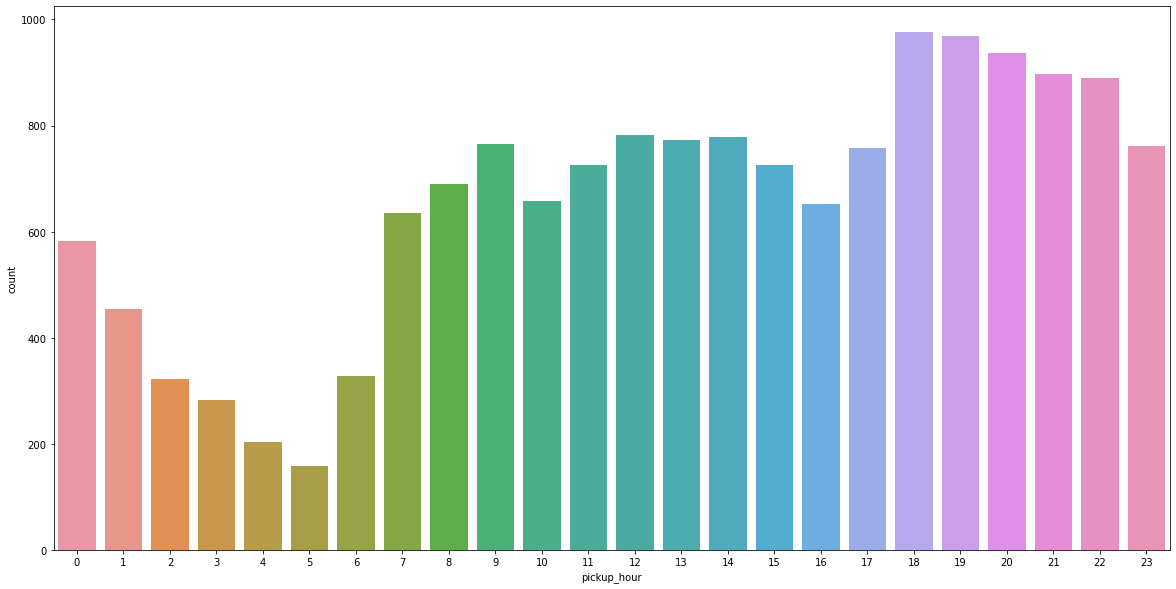

In [247]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['pickup_hour'])

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

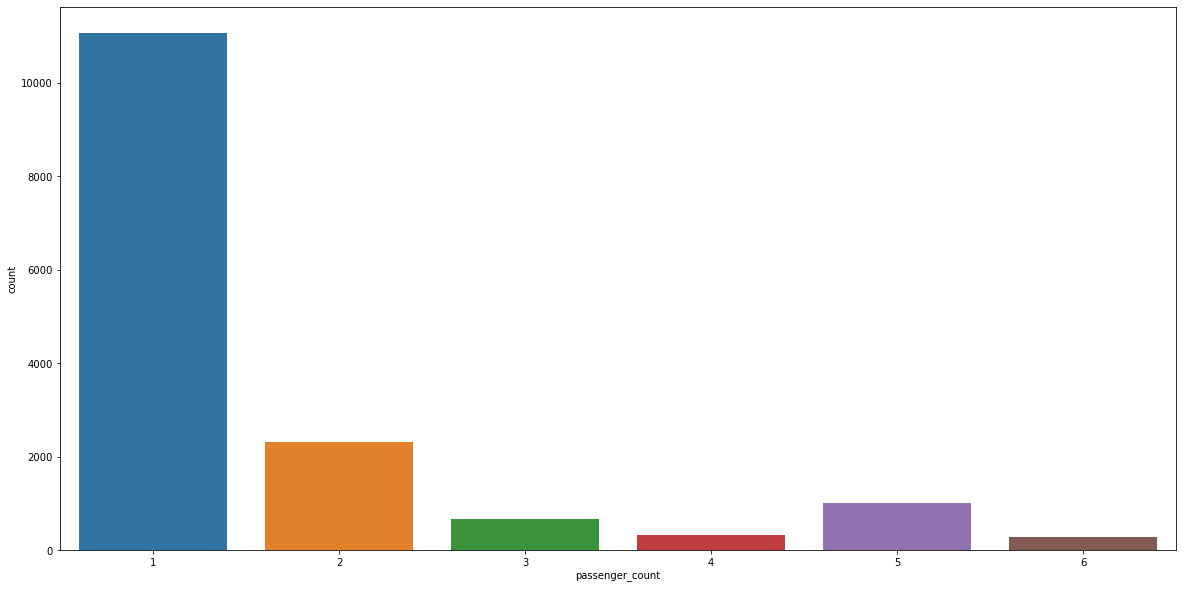

In [248]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['passenger_count'])

# 5.Feature Selection

In [249]:
cat_var=['pickup_year','pickup_month','pickup_day_of_week','pickup_hour','passenger_count']

In [250]:
num_var=['distance','fare_amount']

## 5.1 case 1

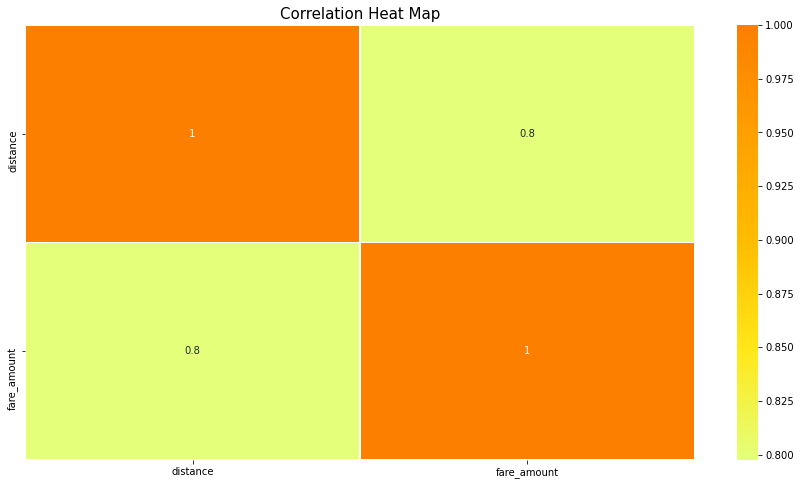

In [251]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_1[num_var].corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='distance', ylabel='fare_amount'>

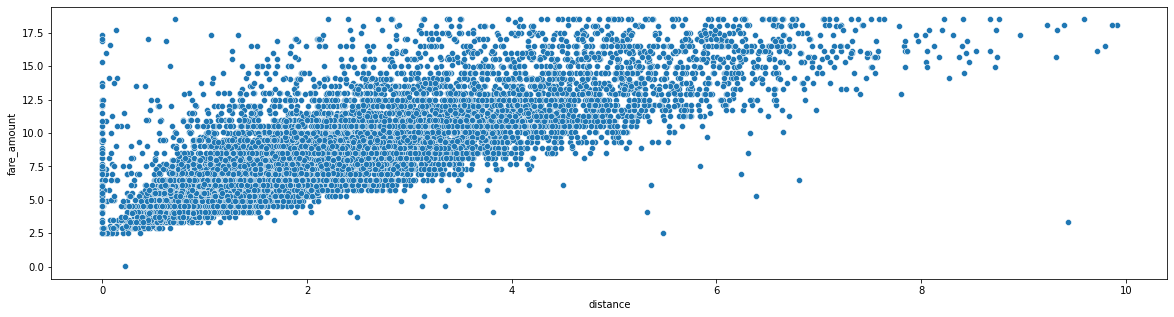

In [252]:
plt.figure(figsize=(20,5)) 
sns.scatterplot(df_1['distance'],df_1['fare_amount'])

## 5.2 case 2

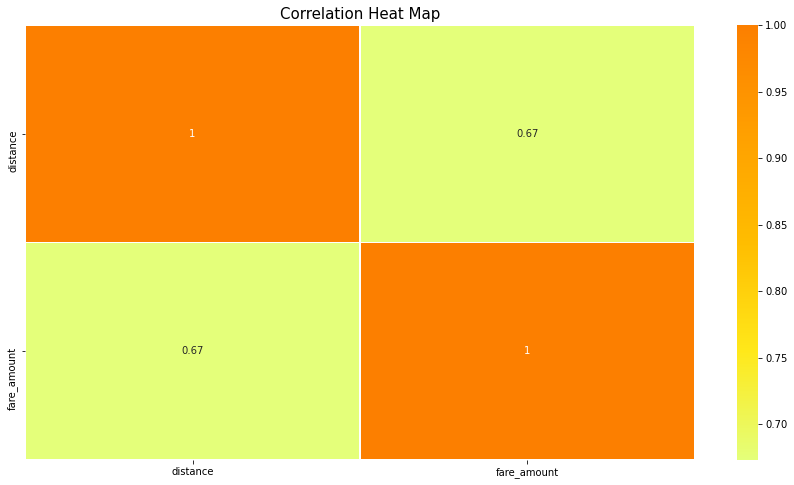

In [253]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_2[num_var].corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='distance', ylabel='fare_amount'>

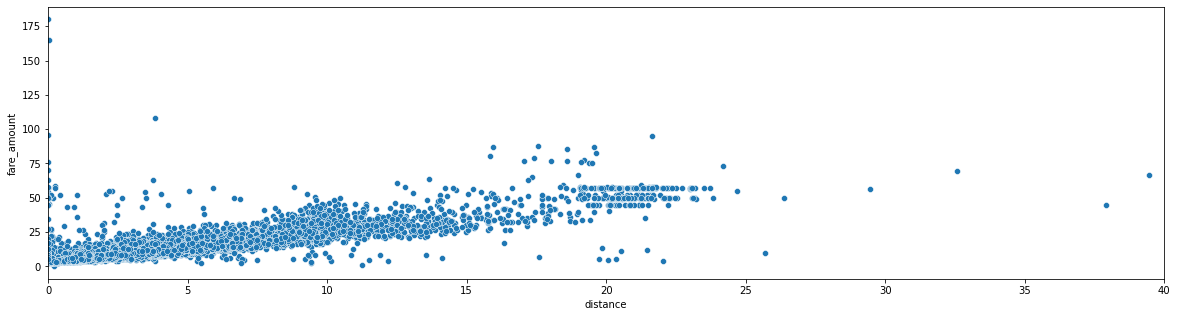

In [254]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,40)
sns.scatterplot(df_2['distance'],df_2['fare_amount'])

## 5.3 case 3

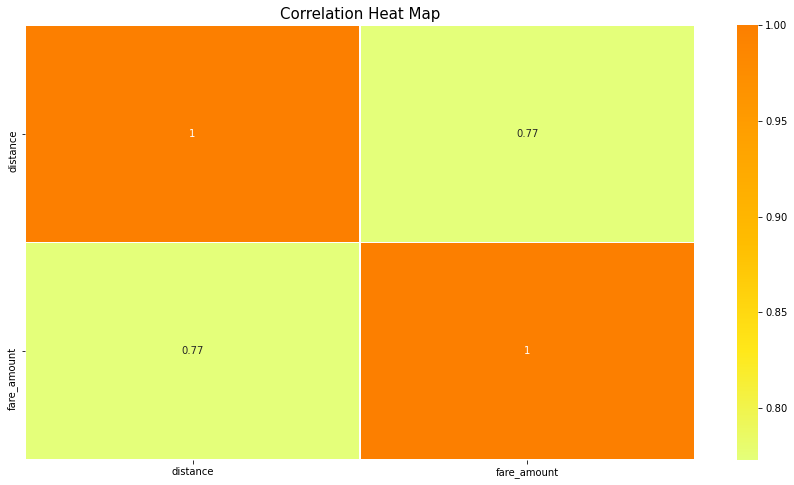

In [255]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_3[num_var].corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='distance', ylabel='fare_amount'>

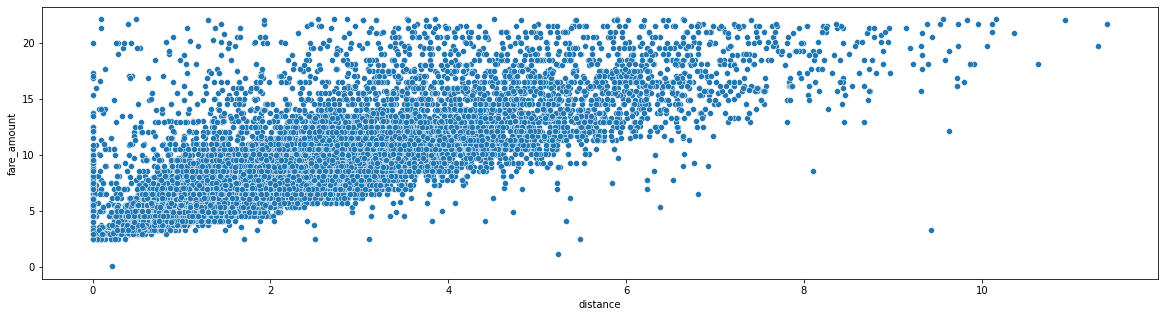

In [256]:
plt.figure(figsize=(20,5)) 
sns.scatterplot(df_3['distance'],df_3['fare_amount'])

## 5.4 case 4

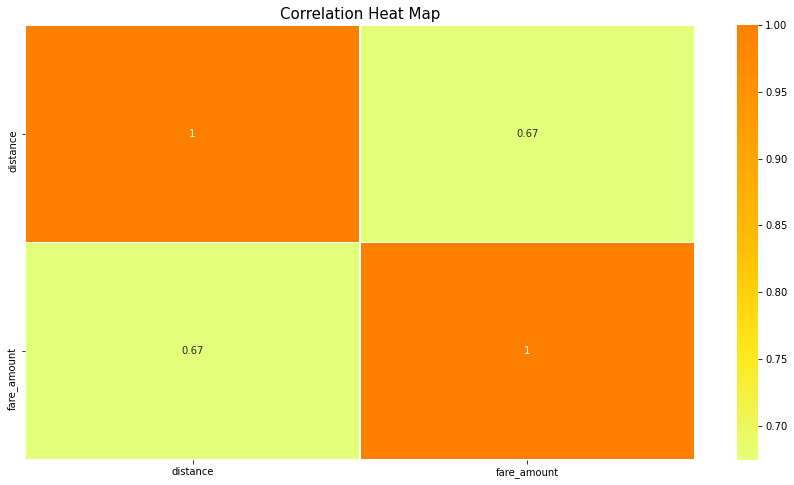

In [257]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_4[num_var].corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

C:\Users\Naveen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='distance', ylabel='fare_amount'>

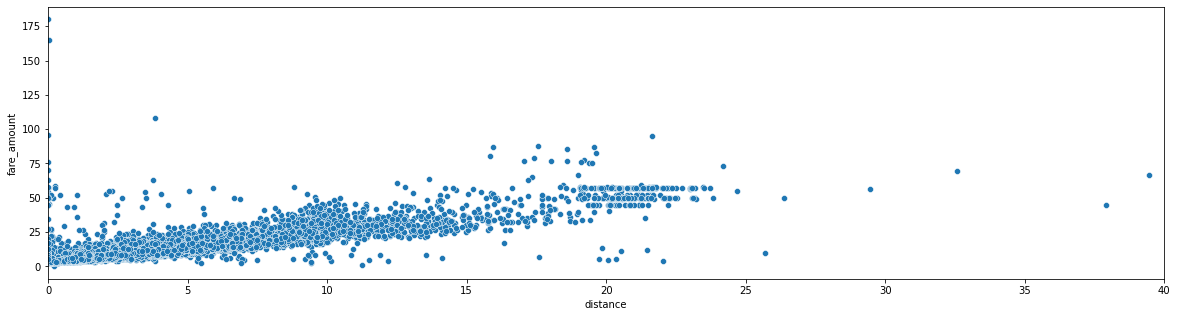

In [258]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,40)
sns.scatterplot(df_4['distance'],df_4['fare_amount'])

# 6.Feature Transformation

## 6.1 distance

In [259]:
#### If you want to check whether feature is guassian or normal distributed
#### Q-Q plot
def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.suptitle(feature, fontsize = 15)
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

### 6.1.1 case 1

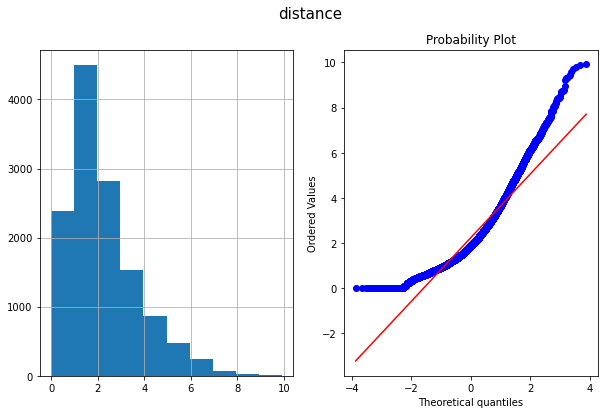

In [260]:
plot_data(df_1,'distance')

#### Not a gaussian distribution

In [261]:
a=pd.DataFrame()

### 6.1.1.1 Logarithmic Transformation

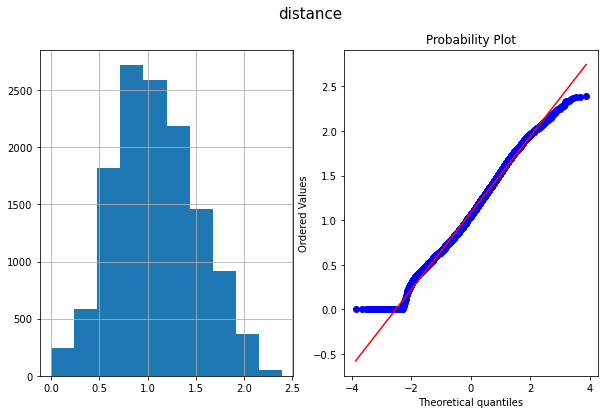

In [262]:
a['distance']=np.log(df_1['distance']+1)
plot_data(a,'distance')

### 6.1.1.2 Reciprocal Transformation

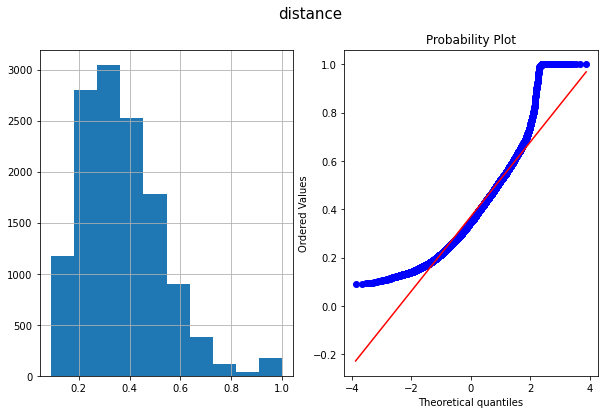

In [263]:
a['distance']=1/(df_1['distance']+1)
plot_data(a,'distance')

### 6.1.1.3 Square Root Transformation

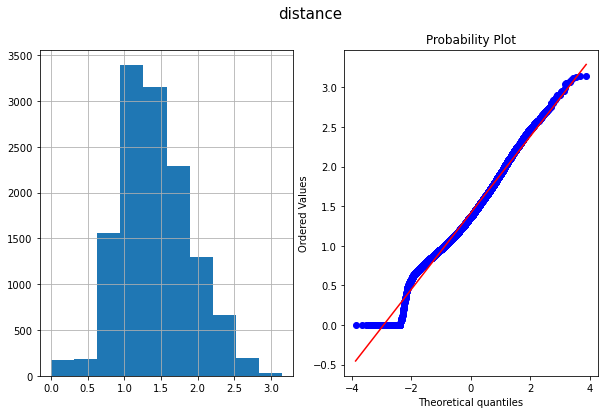

In [264]:
a['distance']=df_1['distance']**(1/2)
plot_data(a,'distance')

### 6.1.1.4 Exponential Transformation

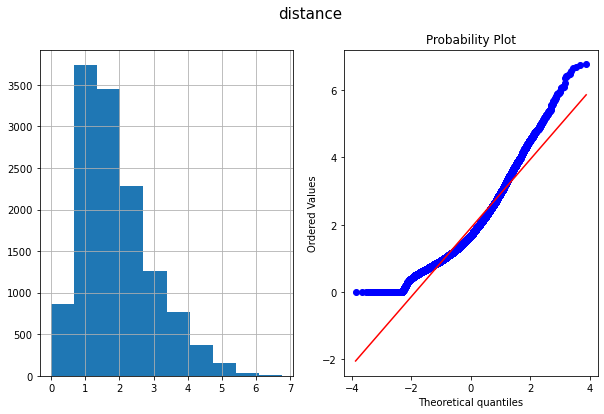

In [265]:
a['distance']=df_1['distance']**(1/1.2)
plot_data(a,'distance')

#### Based on Q-Q plot we select square root transformation for distance variable

In [266]:
df_1['distance']=df_1['distance']**(1/2)

### 6.1.2 case 2

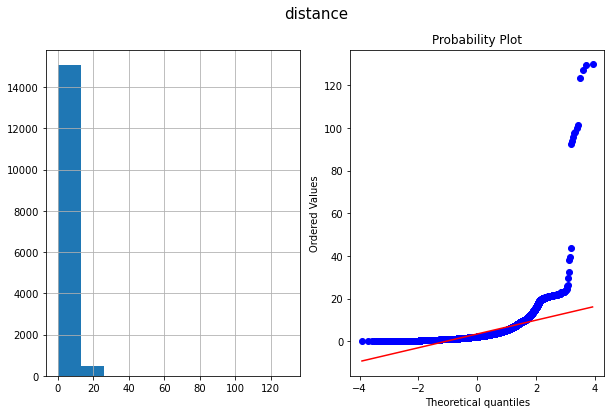

In [267]:
plot_data(df_2,'distance')

#### Not a gaussian distribution

### 6.1.2.1 Logarithmic Transformation

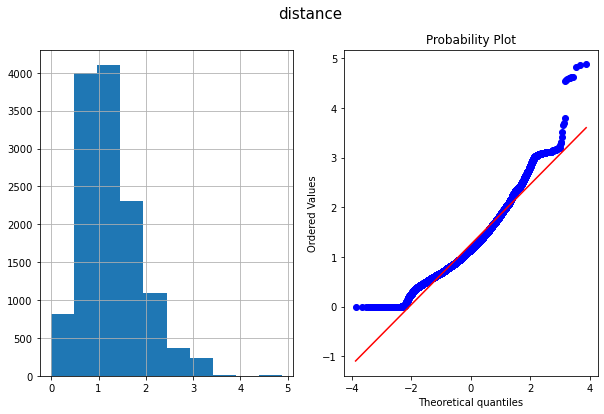

In [268]:
a['distance']=np.log(df_2['distance']+1)
plot_data(a,'distance')

### 6.1.2.2 Reciprocal Transformation

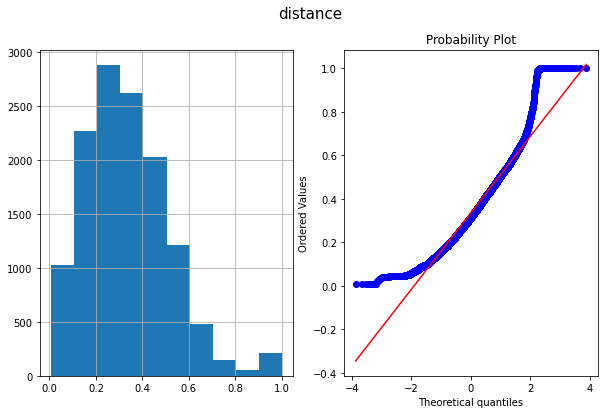

In [269]:
a['distance']=1/(df_2['distance']+1)
plot_data(a,'distance')

### 6.1.2.3 Square Root Transformation

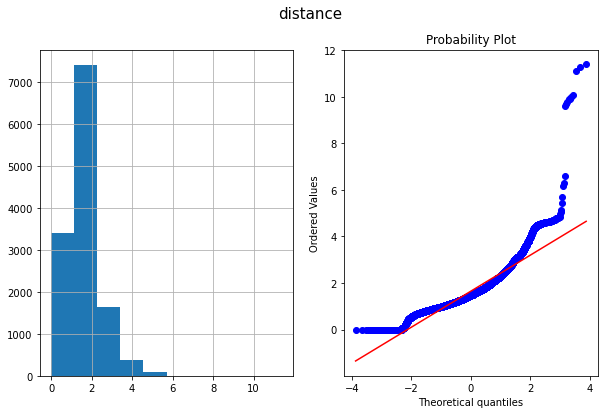

In [270]:
a['distance']=df_2['distance']**(1/2)
plot_data(a,'distance')

### 6.1.2.4 Exponential Transformation

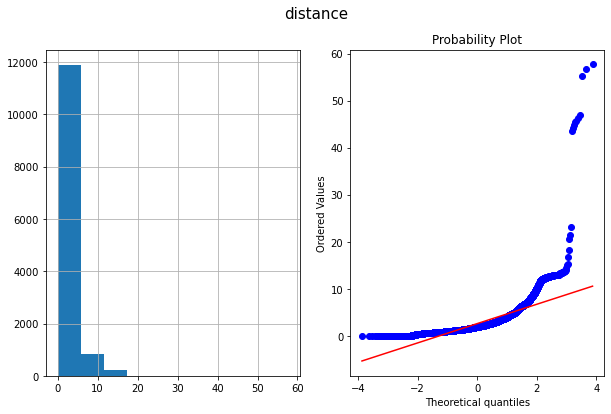

In [271]:
a['distance']=df_2['distance']**(1/1.2)
plot_data(a,'distance')

#### Based on Q-Q plot we select Logarithmic transformation for distance variable

In [272]:
df_2['distance']=np.log(df_2['distance']+1)

### 6.1.3 case 3

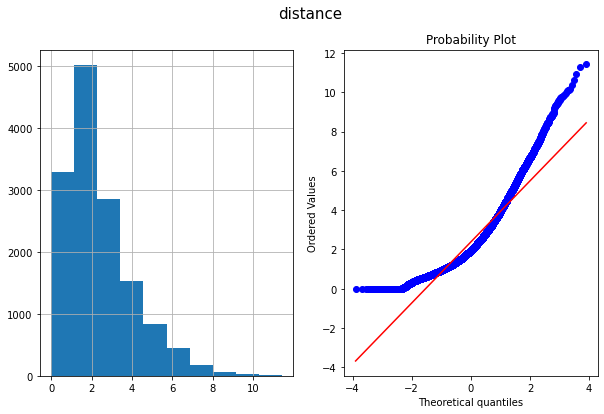

In [273]:
plot_data(df_3,'distance')

#### Not a gaussian distribution

### 6.1.3.1 Logarithmic Transformation

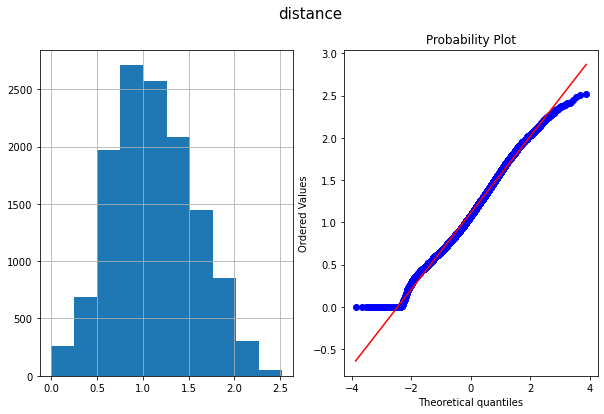

In [274]:
a['distance']=np.log(df_3['distance']+1)
plot_data(a,'distance')

### 6.1.3.2 Reciprocal Transformation

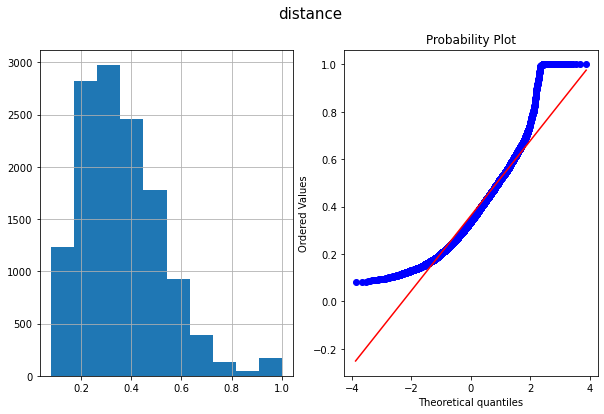

In [275]:
a['distance']=1/(df_3['distance']+1)
plot_data(a,'distance')

### 6.1.3.3 Square Root Transformation

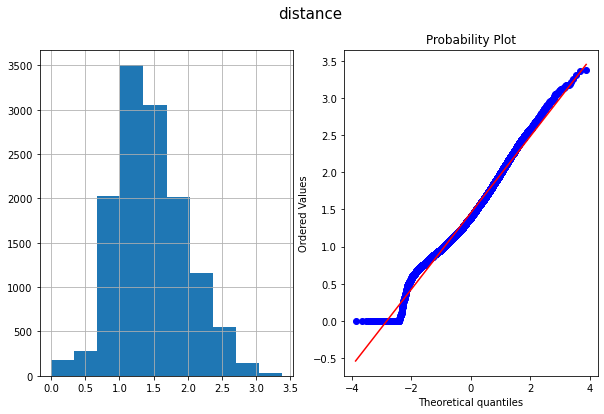

In [276]:
a['distance']=df_3['distance']**(1/2)
plot_data(a,'distance')

### 6.1.3.4 Exponential Transformation

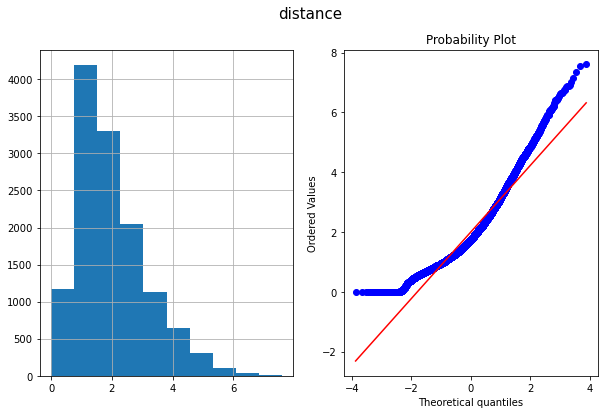

In [277]:
a['distance']=df_3['distance']**(1/1.2)
plot_data(a,'distance')

#### Based on Q-Q plot we select square root transformation for distance variable

In [278]:
df_3['distance']=df_3['distance']**(1/2)

### 6.1.4 case 4

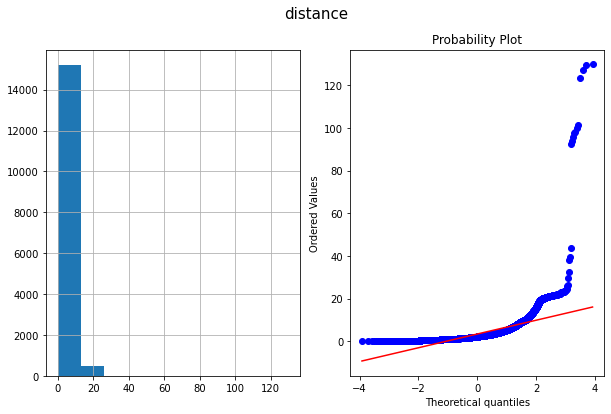

In [279]:
plot_data(df_4,'distance')

#### Not a gaussian distribution

### 6.1.4.1 Logarithmic Transformation

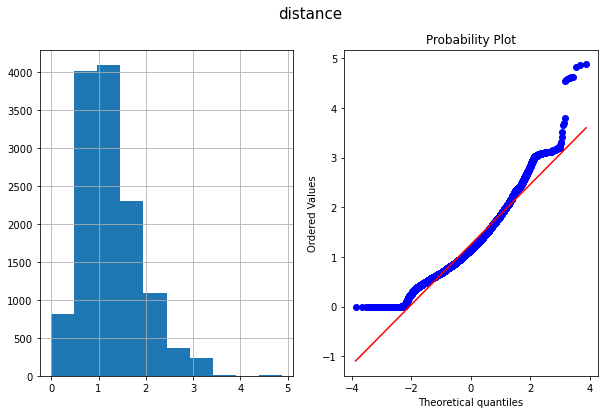

In [280]:
a['distance']=np.log(df_4['distance']+1)
plot_data(a,'distance')

### 6.1.4.2 Reciprocal Transformation

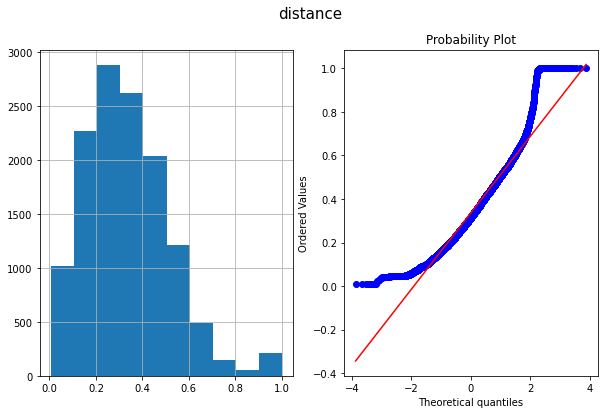

In [281]:
a['distance']=1/(df_4['distance']+1)
plot_data(a,'distance')

### 6.1.4.3 Square Root Transformation

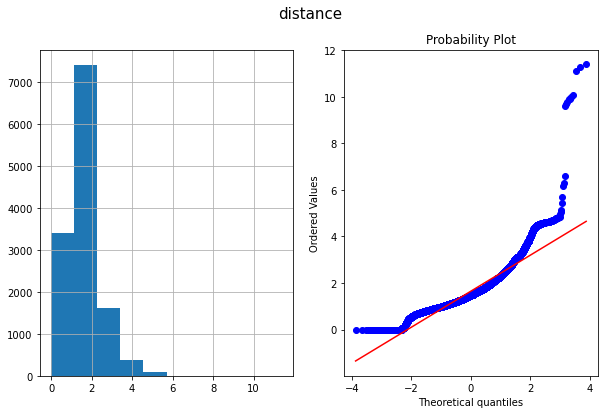

In [282]:
a['distance']=df_4['distance']**(1/2)
plot_data(a,'distance')

### 6.1.4.4 Exponential Transformation

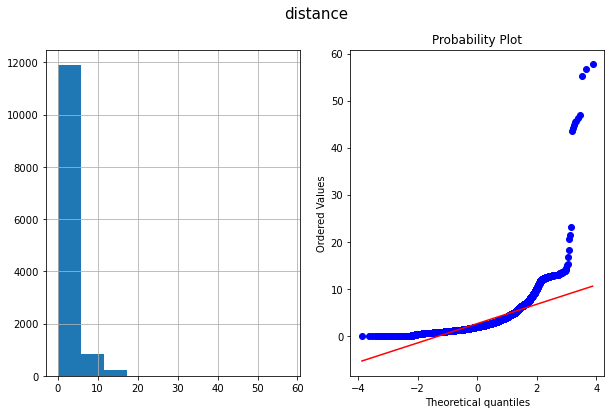

In [283]:
a['distance']=df_4['distance']**(1/1.2)
plot_data(a,'distance')

#### Based on Q-Q plot we select Logarithmic transformation for distance variable

In [284]:
df_4['distance']=np.log(df_4['distance']+1)

# 7.Feature Scaling

## 7.1 case 1

In [285]:
scaler_1=StandardScaler()
df_standard=pd.DataFrame(scaler_1.fit_transform(df_1[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,3.062126
1,-0.492254
2,0.523236
3,-0.008612
4,1.087550


In [286]:
df_1['distance']=df_standard.copy()

## 7.2 case 2

In [287]:
scaler_2=StandardScaler()
df_standard=pd.DataFrame(scaler_2.fit_transform(df_2[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.881008
1,1.607590
2,-0.617026
3,0.132334
4,-0.249392


In [288]:
df_2['distance']=df_standard.copy()

## 7.3 case 3

In [289]:
scaler_3=StandardScaler()
df_standard=pd.DataFrame(scaler_3.fit_transform(df_3[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.829388
1,2.805168
2,-0.534464
3,0.419672
4,-0.080043


In [290]:
df_3['distance']=df_standard.copy()

## 7.4 case 4

In [291]:
scaler_4=StandardScaler()
df_standard=pd.DataFrame(scaler_4.fit_transform(df_4[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.881051
1,1.610251
2,-0.616782
3,0.133393
4,-0.248749


In [292]:
df_4['distance']=df_standard.copy()

# 8.Model Building

## 8.1 Train,Test splitting

### 8.1.1 case 1

In [293]:
df_1.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,1,1,1,16,1,3.062126,16.9
1,2,8,3,0,2,-0.492254,5.7
2,3,4,5,4,1,0.523236,7.7
3,1,3,1,7,1,-0.008612,5.3
4,2,1,3,9,1,1.087550,12.1


In [294]:
x_1=df_1.iloc[:,:-1]
y_1=df_1.iloc[:,-1]

In [295]:
x_1_train,x_1_test,y_1_train,y_1_test=train_test_split(x_1,y_1,train_size=0.7,random_state=1234)

In [296]:
x_1_train.shape

(9054, 6)

In [297]:
x_1_test.shape

(3881, 6)

### 8.1.2 case 2

In [298]:
df_2.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.881008,4.5
1,1,1,1,16,1,1.607590,16.9
2,2,8,3,0,2,-0.617026,5.7
3,3,4,5,4,1,0.132334,7.7
4,1,3,1,7,1,-0.249392,5.3


In [299]:
x_2=df_2.iloc[:,:-1]
y_2=df_2.iloc[:,-1]

In [300]:
x_2_train,x_2_test,y_2_train,y_2_test=train_test_split(x_2,y_2,train_size=0.7,random_state=1234)

In [301]:
x_2_train.shape

(10897, 6)

In [302]:
x_2_test.shape

(4671, 6)

### 8.1.3 case 3

In [303]:
df_3.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.829388,4.5
1,1,1,1,16,1,2.805168,16.9
2,2,8,3,0,2,-0.534464,5.7
3,3,4,5,4,1,0.419672,7.7
4,1,3,1,7,1,-0.080043,5.3


In [304]:
x_3=df_3.iloc[:,:-1]
y_3=df_3.iloc[:,-1]

In [305]:
x_3_train,x_3_test,y_3_train,y_3_test=train_test_split(x_3,y_3,train_size=0.7,random_state=1234)

In [306]:
x_3_train.shape

(9970, 6)

In [307]:
x_3_test.shape

(4274, 6)

### 8.1.4 case 4

In [308]:
df_4.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.881051,4.5
1,1,1,1,16,1,1.610251,16.9
2,2,8,3,0,2,-0.616782,5.7
3,3,4,5,4,1,0.133393,7.7
4,1,3,1,7,1,-0.248749,5.3


In [309]:
x_4=df_4.iloc[:,:-1]
y_4=df_4.iloc[:,-1]

In [310]:
x_4_train,x_4_test,y_4_train,y_4_test=train_test_split(x_4,y_4,train_size=0.7,random_state=1234)

In [311]:
x_4_train.shape

(10991, 6)

In [312]:
x_4_test.shape

(4711, 6)

## 8.2 Linear Regression

In [313]:
# function to calculate adjusted r^2
def adj_r2(x,y,model):
    r2=model.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [314]:
# function to calculate MAPE
def MAPE(y_true,y_pred):
    mape=np.mean(np.abs((y_true-y_pred)/y_true))*100
    return mape

### 8.2.1 case 1

In [315]:
LR_1 = LinearRegression()
LR_1.fit(x_1_train,y_1_train)

LinearRegression()

In [316]:
LR_1.coef_

array([ 0.31426912,  0.04444889, -0.02252148,  0.00908665,  0.05022062,
        2.71196069])

In [317]:
y_pred_LR_1=LR_1.predict(x_1_test)

In [318]:
# r^2 value
LR_1.score(x_1_train,y_1_train)

0.6414003573436033

In [319]:
# r^2 value
LR_1.score(x_1_test,y_1_test)

0.6320031129792776

In [320]:
# adjusted r^2 value
adj_r2(x_1_train,y_1_train,LR_1)

0.6411625328873263

In [321]:
# adjusted r^2 value
adj_r2(x_1_test,y_1_test,LR_1)

0.6314331642642222

In [322]:
# MAPE value
MAPE(y_1_test,y_pred_LR_1)

20.07057399378251

### 8.2.2 case 2

In [323]:
LR_2 = LinearRegression()
LR_2.fit(x_2_train,y_2_train)

LinearRegression()

In [324]:
LR_2.coef_

array([ 5.05256179e-01,  9.86983002e-02, -6.01341348e-02, -1.27315130e-03,
       -2.17896409e-02,  7.05902019e+00])

In [325]:
y_pred_LR_2=LR_2.predict(x_2_test)

In [326]:
# r^2 value
LR_2.score(x_2_train,y_2_train)

0.5557054079558792

In [327]:
# r^2 value
LR_2.score(x_2_test,y_2_test)

0.5974032598363073

In [328]:
# adjusted r^2 value
adj_r2(x_2_train,y_2_train,LR_2)

0.5554606175470395

In [329]:
# adjusted r^2 value
adj_r2(x_2_test,y_2_test,LR_2)

0.5968853395016198

In [330]:
# MAPE value
MAPE(y_2_test,y_pred_LR_2)

33.37348616068679

### 8.2.3 case 3

In [331]:
LR_3 = LinearRegression()
LR_3.fit(x_3_train,y_3_train)

LinearRegression()

In [332]:
LR_3.coef_

array([ 3.54310222e-01,  6.12048120e-02, -3.25388092e-02, -2.74079400e-03,
        3.18224615e-02,  3.10288590e+00])

In [333]:
y_pred_LR_3=LR_3.predict(x_3_test)

In [334]:
# r^2 value
LR_3.score(x_3_train,y_3_train)

0.5883663887146287

In [335]:
# r^2 value
LR_3.score(x_3_test,y_3_test)

0.6108127249222137

In [336]:
# adjusted r^2 value
adj_r2(x_3_train,y_3_train,LR_3)

0.5881184913275253

In [337]:
# adjusted r^2 value
adj_r2(x_3_test,y_3_test,LR_3)

0.6102654730706865

In [338]:
# MAPE value
MAPE(y_3_test,y_pred_LR_3)

22.13191431983217

### 8.2.4 case 4

In [339]:
LR_4 = LinearRegression()
LR_4.fit(x_4_train,y_4_train)

LinearRegression()

In [340]:
LR_4.coef_

array([ 0.51437825,  0.09811694, -0.08052858, -0.00982816,  0.02936942,
        7.27494434])

In [341]:
y_pred_LR_4=LR_4.predict(x_4_test)

In [342]:
# r^2 value
LR_4.score(x_4_train,y_4_train)

0.5810026253569174

In [343]:
# r^2 value
LR_4.score(x_4_test,y_4_test)

0.5398080893132247

In [344]:
# adjusted r^2 value
adj_r2(x_4_train,y_4_train,LR_4)

0.5807737484224802

In [345]:
# adjusted r^2 value
adj_r2(x_4_test,y_4_test,LR_4)

0.5392211098353078

In [346]:
# MAPE value
MAPE(y_4_test,y_pred_LR_4)

33.993282495310005

## 8.3 KNN algorithm

### 8.3.1 case 1

In [347]:
KNN_1=KNeighborsRegressor()

In [348]:
KNN_1.fit(x_1_train,y_1_train)

KNeighborsRegressor()

In [349]:
y_pred_KNN_1=KNN_1.predict(x_1_test)

In [350]:
# r^2 value
KNN_1.score(x_1_train,y_1_train)

0.6994548627516185

In [351]:
# r^2 value
KNN_1.score(x_1_test,y_1_test)

0.5321865954856575

In [352]:
# adjusted r^2 value
adj_r2(x_1_train,y_1_train,KNN_1)

0.699255540233271

In [353]:
# adjusted r^2 value
adj_r2(x_1_test,y_1_test,KNN_1)

0.5314620522675144

In [354]:
# MAPE value
MAPE(y_1_test,y_pred_KNN_1)

23.547339339238633

### 8.3.1.1 Hyper parameter Tuning

In [355]:
param_grid = { 'n_neighbors' : list(range(3,14)),
               'weights'     : ['uniform','distance'],
               'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size'   : list(range(1,15)),
               'p'           : [2,1]
              }

In [527]:
gridsearch = GridSearchCV(KNN_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 2464 candidates, totalling 12320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 3064 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 4024 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7672 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9144 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 10040 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 10904 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 11832 tasks    

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=2,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=9, p=2,
                                           weights='distance'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [528]:
gridsearch.best_params_

{'algorithm': 'auto',
 'leaf_size': 2,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'distance'}

In [356]:
KNN_1=KNeighborsRegressor(algorithm='auto', leaf_size= 2, n_neighbors= 9, p=2, weights='distance')
KNN_1.fit(x_1_train,y_1_train)
y_pred_KNN_1=KNN_1.predict(x_1_test)

In [357]:
# r^2 value
KNN_1.score(x_1_train,y_1_train)

1.0

In [358]:
# r^2 value
KNN_1.score(x_1_test,y_1_test)

0.5566451606448065

In [359]:
# adjusted r^2 value
adj_r2(x_1_train,y_1_train,KNN_1)

1.0

In [360]:
# adjusted r^2 value
adj_r2(x_1_test,y_1_test,KNN_1)

0.5559584985291299

In [361]:
# MAPE value
MAPE(y_1_test,y_pred_KNN_1)

23.10857132982102

### 8.3.2 case 2

In [363]:
KNN_2=KNeighborsRegressor()

In [364]:
KNN_2.fit(x_2_train,y_2_train)

KNeighborsRegressor()

In [365]:
y_pred_KNN_2=KNN_2.predict(x_2_test)

In [366]:
# r^2 value
KNN_2.score(x_2_train,y_2_train)

0.7059054135085538

In [367]:
# r^2 value
KNN_2.score(x_2_test,y_2_test)

0.6197579819347441

In [368]:
# adjusted r^2 value
adj_r2(x_2_train,y_2_train,KNN_2)

0.7057433779237101

In [369]:
# adjusted r^2 value
adj_r2(x_2_test,y_2_test,KNN_2)

0.6192688198188796

In [370]:
# MAPE value
MAPE(y_2_test,y_pred_KNN_2)

29.460303858150944

### 8.3.2.1 Hyper parameter Tuning

In [371]:
param_grid = { 'n_neighbors' : list(range(3,14)),
               'weights'     : ['uniform','distance'],
               'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size'   : list(range(1,15)),
               'p'           : [2,1]
              }

In [372]:
gridsearch = GridSearchCV(KNN_2, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_2_train,y_2_train)

Fitting 5 folds for each of 2464 candidates, totalling 12320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1264 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 3760 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 4848 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 6064 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 7408 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 8880 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 9904 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 10768 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 11696 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 12320 out of 1

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             verbose=3)

In [547]:
gridsearch.best_params_

{'algorithm': 'auto',
 'leaf_size': 1,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'distance'}

In [374]:
KNN_2=KNeighborsRegressor(algorithm='auto', leaf_size= 1, n_neighbors= 8, p=2, weights='distance')
KNN_2.fit(x_2_train,y_2_train)
y_pred_KNN_2=KNN_2.predict(x_2_test)

In [375]:
# r^2 value
KNN_2.score(x_2_train,y_2_train)

1.0

In [376]:
# r^2 value
KNN_2.score(x_2_test,y_2_test)

0.616815092102156

In [377]:
# adjusted r^2 value
adj_r2(x_2_train,y_2_train,KNN_2)

1.0

In [378]:
# adjusted r^2 value
adj_r2(x_2_test,y_2_test,KNN_2)

0.6163221441074332

In [379]:
# MAPE value
MAPE(y_2_test,y_pred_KNN_2)

28.346267918849794

### 8.3.3 case 3

In [381]:
KNN_3=KNeighborsRegressor()

In [382]:
KNN_3.fit(x_3_train,y_3_train)

KNeighborsRegressor()

In [383]:
y_pred_KNN_3=KNN_3.predict(x_3_test)

In [384]:
# r^2 value
KNN_3.score(x_3_train,y_3_train)

0.6566057161614967

In [385]:
# r^2 value
KNN_3.score(x_3_test,y_3_test)

0.5067300621703871

In [386]:
# adjusted r^2 value
adj_r2(x_3_train,y_3_train,KNN_3)

0.6563989144247677

In [387]:
# adjusted r^2 value
adj_r2(x_3_test,y_3_test,KNN_3)

0.5060364555083348

In [388]:
# MAPE value
MAPE(y_3_test,y_pred_KNN_3)

25.956391519171984

### 8.3.3.1 Hyper parameter Tuning

In [557]:
param_grid = { 'n_neighbors' : list(range(3,14)),
               'weights'     : ['uniform','distance'],
               'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size'   : list(range(1,15)),
               'p'           : [2,1]
              }

In [558]:
gridsearch = GridSearchCV(KNN_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 2464 candidates, totalling 12320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 3064 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 4024 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7672 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9144 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 10028 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 10892 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 11820 tasks    

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [390]:
gridsearch.best_params_

{'algorithm': 'auto',
 'leaf_size': 1,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'distance'}

In [391]:
KNN_3=KNeighborsRegressor(algorithm='brute', leaf_size= 1, n_neighbors= 10, p=2, weights='distance')
KNN_3.fit(x_3_train,y_3_train)
y_pred_KNN_3=KNN_3.predict(x_3_test)

In [392]:
# r^2 value
KNN_3.score(x_3_train,y_3_train)

0.9999999999999992

In [393]:
# r^2 value
KNN_3.score(x_3_test,y_3_test)

0.5310313994380691

In [394]:
# adjusted r^2 value
adj_r2(x_3_train,y_3_train,KNN_3)

0.9999999999999992

In [395]:
# adjusted r^2 value
adj_r2(x_3_test,y_3_test,KNN_3)

0.5303719638619333

In [396]:
# MAPE value
MAPE(y_3_test,y_pred_KNN_3)

25.252862484389166

### 8.3.4 case 4

In [398]:
KNN_4=KNeighborsRegressor()

In [399]:
KNN_4.fit(x_4_train,y_4_train)

KNeighborsRegressor()

In [400]:
y_pred_KNN_4=KNN_4.predict(x_4_test)

In [401]:
# r^2 value
KNN_4.score(x_4_train,y_4_train)

0.7349085592780472

In [402]:
# r^2 value
KNN_4.score(x_4_test,y_4_test)

0.5595943750959731

In [403]:
# adjusted r^2 value
adj_r2(x_4_train,y_4_train,KNN_4)

0.7347637533198961

In [404]:
# adjusted r^2 value
adj_r2(x_4_test,y_4_test,KNN_4)

0.5590326332274731

In [405]:
# MAPE value
MAPE(y_4_test,y_pred_KNN_4)

30.223749504520097

### 8.3.4.1 Hyper parameter Tuning

In [407]:
param_grid = { 'n_neighbors' : list(range(3,14)),
               'weights'     : ['uniform','distance'],
               'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size'   : list(range(1,15)),
               'p'           : [2,1]
              }

In [568]:
gridsearch = GridSearchCV(KNN_4, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_4_train,y_4_train)

Fitting 5 folds for each of 2464 candidates, totalling 12320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 2224 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 3312 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 4528 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 7344 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 8944 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9992 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 10920 tasks      |

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='brute', leaf_size=0,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=6, p=2,
                                           weights='distance'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [569]:
gridsearch.best_params_

{'algorithm': 'brute',
 'leaf_size': 1,
 'n_neighbors': 6,
 'p': 2,
 'weights': 'distance'}

In [408]:
KNN_4=KNeighborsRegressor(algorithm='brute', leaf_size= 1, n_neighbors= 6, p=2, weights='distance')
KNN_4.fit(x_4_train,y_4_train)
y_pred_KNN_4=KNN_4.predict(x_4_test)

In [409]:
# r^2 value
KNN_4.score(x_4_train,y_4_train)

0.9999999999999989

In [410]:
# r^2 value
KNN_4.score(x_4_test,y_4_test)

0.566489250865319

In [411]:
# adjusted r^2 value
adj_r2(x_4_train,y_4_train,KNN_4)

0.9999999999999989

In [412]:
# adjusted r^2 value
adj_r2(x_4_test,y_4_test,KNN_4)

0.5659363034812186

In [413]:
# MAPE value
MAPE(y_4_test,y_pred_KNN_4)

29.43639821314265

## 8.4 Decision Tree Regression

### 8.4.1 case 1

In [416]:
DT_1=DecisionTreeRegressor()

In [417]:
DT_1.fit(x_1_train,y_1_train)

DecisionTreeRegressor()

In [418]:
y_pred_DT_1=DT_1.predict(x_1_test)

In [419]:
# r^2 value
DT_1.score(x_1_train,y_1_train)

1.0

In [420]:
# r^2 value
DT_1.score(x_1_test,y_1_test)

0.3763737182851099

In [421]:
# adjusted r^2 value
adj_r2(x_1_train,y_1_train,DT_1)

1.0

In [422]:
# adjusted r^2 value
adj_r2(x_1_test,y_1_test,DT_1)

0.3754078541420306

In [423]:
# MAPE value
MAPE(y_1_test,y_pred_DT_1)

25.188083643745195

### 8.4.1.1 Hyper parameter Tuning

In [453]:
param_grid = { 'criterion'         : ["mse", "friedman_mse", "mae"],
               'splitter'          : ["best", "random"],
               'max_depth'         : list(range(1,10)),
               'min_samples_split' : list(range(1,6)),
               'min_samples_leaf'  : list(range(1,10)),
              'max_features'       : ["auto", "sqrt", "log2"]
              }

In [454]:
gridsearch = GridSearchCV(DT_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 5352 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 12520 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 21736 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 25632 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 26084 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 26564 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 27108 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 27716 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 28388 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 29124 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 29924 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 30788 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3171

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                 

In [455]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

In [425]:
DT_1=DecisionTreeRegressor(criterion= 'mse',max_depth= 6,max_features= 'auto',min_samples_leaf= 5,min_samples_split= 2,splitter= 'best')
DT_1.fit(x_1_train,y_1_train)
y_pred_DT_1=DT_1.predict(x_1_test)

In [426]:
# r^2 value
DT_1.score(x_1_train,y_1_train)

0.7128049021931815

In [427]:
# r^2 value
DT_1.score(x_1_test,y_1_test)

0.6836723417423216

In [428]:
# adjusted r^2 value
adj_r2(x_1_train,y_1_train,DT_1)

0.7126144334646702

In [429]:
# adjusted r^2 value
adj_r2(x_1_test,y_1_test,DT_1)

0.6831824176458977

In [430]:
# MAPE value
MAPE(y_1_test,y_pred_DT_1)

18.055058438880696

### 8.4.2 case 2

In [431]:
DT_2=DecisionTreeRegressor()

In [432]:
DT_2.fit(x_2_train,y_2_train)

DecisionTreeRegressor()

In [433]:
y_pred_DT_2=DT_2.predict(x_2_test)

In [434]:
# r^2 value
DT_2.score(x_2_train,y_2_train)

1.0

In [435]:
# r^2 value
DT_2.score(x_2_test,y_2_test)

0.6336628495021257

In [436]:
# adjusted r^2 value
adj_r2(x_2_train,y_2_train,DT_2)

1.0

In [437]:
# adjusted r^2 value
adj_r2(x_2_test,y_2_test,DT_2)

0.6331915752947956

In [438]:
# MAPE value
MAPE(y_2_test,y_pred_DT_2)

29.12624438760489

### 8.4.2.1 Hyper parameter Tuning

In [472]:
param_grid = { 'criterion'         : ["mse", "friedman_mse", "mae"],
               'splitter'          : ["best", "random"],
               'max_depth'         : list(range(1,10)),
               'min_samples_split' : list(range(1,10)),
               'min_samples_leaf'  : list(range(1,10)),
              'max_features'       : ["auto", "sqrt", "log2"]
              }

In [473]:
gridsearch = GridSearchCV(DT_2, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_2_train,y_2_train)

Fitting 5 folds for each of 13122 candidates, totalling 65610 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3048 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 6632 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 11240 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 16872 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 23528 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 31208 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 39912 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 44684 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 45356 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 46092 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 46892 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 47756 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 48684

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                 

In [474]:
gridsearch.best_params_

{'criterion': 'mae',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'splitter': 'best'}

In [439]:
DT_2=DecisionTreeRegressor(criterion= 'mae',max_depth= 5,max_features= 'auto',min_samples_leaf= 3,min_samples_split= 7,splitter= 'best')
DT_2.fit(x_2_train,y_2_train)
y_pred_DT_2=DT_2.predict(x_2_test)

In [440]:
# r^2 value
DT_2.score(x_2_train,y_2_train)

0.7234940039641211

In [441]:
# r^2 value
DT_2.score(x_2_test,y_2_test)

0.7869679780410244

In [442]:
# adjusted r^2 value
adj_r2(x_2_train,y_2_train,DT_2)

0.723341659062724

In [443]:
# adjusted r^2 value
adj_r2(x_2_test,y_2_test,DT_2)

0.7866939231242676

In [444]:
# MAPE value
MAPE(y_2_test,y_pred_DT_2)

18.867174086933343

### 8.4.3 case 3

In [446]:
DT_3=DecisionTreeRegressor()

In [447]:
DT_3.fit(x_3_train,y_3_train)

DecisionTreeRegressor()

In [448]:
y_pred_DT_3=DT_3.predict(x_3_test)

In [449]:
# r^2 value
DT_3.score(x_3_train,y_3_train)

1.0

In [450]:
# r^2 value
DT_3.score(x_3_test,y_3_test)

0.26261369681347013

In [451]:
# adjusted r^2 value
adj_r2(x_3_train,y_3_train,DT_3)

1.0

In [452]:
# adjusted r^2 value
adj_r2(x_3_test,y_3_test,DT_3)

0.26157682832996443

In [453]:
# MAPE value
MAPE(y_3_test,y_pred_DT_3)

29.52344318540721

### 8.4.3.1 Hyper parameter Tuning

In [497]:
param_grid = { 'criterion'         : ["mse", "friedman_mse", "mae"],
               'splitter'          : ["best", "random"],
               'max_depth'         : list(range(1,10)),
               'min_samples_split' : list(range(1,10)),
               'min_samples_leaf'  : list(range(1,15)),
              'max_features'       : ["auto", "sqrt", "log2"]
              }

In [498]:
gridsearch = GridSearchCV(DT_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 20412 candidates, totalling 102060 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 11032 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 20248 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 31512 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 44824 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 60184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 69432 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 70040 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 71020 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 72192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 72992 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 73856 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7478

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                 

In [499]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 3,
 'splitter': 'best'}

In [455]:
DT_3=DecisionTreeRegressor(criterion= 'mse',max_depth= 5,max_features= 'auto',min_samples_leaf= 8,min_samples_split= 3,splitter= 'best')
DT_3.fit(x_3_train,y_3_train)
y_pred_DT_3=DT_3.predict(x_3_test)

In [456]:
# r^2 value
DT_3.score(x_3_train,y_3_train)

0.6406935466975792

In [457]:
# r^2 value
DT_3.score(x_3_test,y_3_test)

0.6469408479181591

In [458]:
# adjusted r^2 value
adj_r2(x_3_train,y_3_train,DT_3)

0.6404771622029677

In [459]:
# adjusted r^2 value
adj_r2(x_3_test,y_3_test,DT_3)

0.6464443972707508

In [460]:
# MAPE value
MAPE(y_3_test,y_pred_DT_3)

20.560161876506253

### 8.4.4 case 4

In [462]:
DT_4=DecisionTreeRegressor()

In [463]:
DT_4.fit(x_4_train,y_4_train)

DecisionTreeRegressor()

In [464]:
y_pred_DT_4=DT_4.predict(x_4_test)

In [465]:
# r^2 value
DT_4.score(x_4_train,y_4_train)

1.0

In [466]:
# r^2 value
DT_4.score(x_4_test,y_4_test)

0.3354174514327565

In [467]:
# adjusted r^2 value
adj_r2(x_4_train,y_4_train,DT_4)

1.0

In [468]:
# adjusted r^2 value
adj_r2(x_4_test,y_4_test,DT_4)

0.33456976961060436

In [469]:
# MAPE value
MAPE(y_4_test,y_pred_DT_4)

33.18663746148764

### 8.4.4.1 Hyper parameter Tuning

In [516]:
param_grid = { 'criterion'         : ["mse", "friedman_mse", "mae"],
               'splitter'          : ["best", "random"],
               'max_depth'         : list(range(1,10)),
               'min_samples_split' : list(range(1,7)),
               'min_samples_leaf'  : list(range(1,7)),
              'max_features'       : ["auto", "sqrt", "log2"]
              }

In [517]:
gridsearch = GridSearchCV(DT_4, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_4_train,y_4_train)

Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3048 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 6632 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 11240 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 16872 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 20192 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 20672 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 21216 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 21824 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 22496 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 23232 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 24032 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 24896 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 25824

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                 

In [518]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'splitter': 'best'}

In [471]:
DT_4=DecisionTreeRegressor(criterion= 'mse',max_depth= 5,max_features= 'auto',min_samples_leaf= 4,min_samples_split= 2,splitter= 'best')
DT_4.fit(x_4_train,y_4_train)
y_pred_DT_4=DT_4.predict(x_4_test)

In [472]:
# r^2 value
DT_4.score(x_4_train,y_4_train)

0.7794308978103417

In [473]:
# r^2 value
DT_4.score(x_4_test,y_4_test)

0.708244334658197

In [474]:
# adjusted r^2 value
adj_r2(x_4_train,y_4_train,DT_4)

0.77931041213908

In [475]:
# adjusted r^2 value
adj_r2(x_4_test,y_4_test,DT_4)

0.7078721973299549

In [476]:
# MAPE value
MAPE(y_4_test,y_pred_DT_4)

23.609271309573227

## 8.5 Random Forest Regression

### 8.5.1 case 1

In [479]:
RF_1=RandomForestRegressor()

In [480]:
RF_1.fit(x_1_train,y_1_train)

RandomForestRegressor()

In [481]:
y_pred_RF_1=RF_1.predict(x_1_test)

In [482]:
# r^2 value
RF_1.score(x_1_train,y_1_train)

0.956916400100928

In [483]:
# r^2 value
RF_1.score(x_1_test,y_1_test)

0.6722403763042137

In [484]:
# adjusted r^2 value
adj_r2(x_1_train,y_1_train,RF_1)

0.956887826916514

In [485]:
# adjusted r^2 value
adj_r2(x_1_test,y_1_test,RF_1)

0.6717327465308078

In [486]:
# MAPE value
MAPE(y_1_test,y_pred_RF_1)

18.71907125623856

### 8.5.1.1 Hyper parameter Tuning

In [337]:
param_grid = { 'n_estimators'      : list(range(1,200,50)),
               'criterion'         : ["mse","mae"],
               'max_depth'         : list(range(1,6)),
               'min_samples_split' : list(range(1,6)),
               'min_samples_leaf'  : list(range(1,6)),
               'max_features'      : ["auto", "sqrt", "log2"],
               'max_leaf_nodes'    : list(range(1,6)),
               'n_jobs'            : [-1]  
              }

In [ ]:
gridsearch = GridSearchCV(RF_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 15000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 972 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2252 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3084 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4044 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5132 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 6348 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 7692 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 8704 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 9528 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 10800 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 12656 tasks      

In [683]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 50,
 'n_jobs': -1}

In [595]:
param_grid = { 'n_estimators'      : list(range(5,60)),
               'criterion'         : ["mse"],
               'max_depth'         : list(range(2,5)),
               'min_samples_split' : list(range(2,7)),
               'min_samples_leaf'  : list(range(1,4)),
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,7)),
               'n_jobs'            : [-1]  
              }

In [596]:
gridsearch = GridSearchCV(RF_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 12375 candidates, totalling 61875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | 

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, r...
             param_grid={'criterion': ['mse'], 'max_depth': [2, 3, 4],
                         'max_features': ['auto'],

In [597]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 25,
 'n_jobs': -1}

In [601]:
param_grid = { 'n_estimators'      : list(range(20,31)),
               'criterion'         : ["mse"],
               'max_depth'         : list(range(3,10)),
               'min_samples_split' : list(range(2,11)),
               'min_samples_leaf'  : list(range(2,11)),
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(5,15)),
               'n_jobs'            : [-1]  
              }

In [602]:
gridsearch = GridSearchCV(RF_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 62370 candidates, totalling 311850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | 

KeyboardInterrupt: 

exception calling callback for <Future at 0x208ae969388 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\ptyin\anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\ptyin\anaconda3\lib\site-packages\joblib\parallel.py", line 340, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\ptyin\anaconda3\lib\site-packages\joblib\parallel.py", line 769, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\ptyin\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\ptyin\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\ptyin\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 551, in apply_async
    future = self._workers.submit(SafeFunction(func))
AttributeError:

In [600]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 6,
 'min_samples_split': 4,
 'n_estimators': 23,
 'n_jobs': -1}

In [ ]:
param_grid = { 'n_estimators'      : list(range(20,31)),
               'criterion'         : ["mse"],
               'max_depth'         : list(range(3,10)),
               'min_samples_split' : list(range(2,7)),
               'min_samples_leaf'  : list(range(2,7)),
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(5,10)),
               'n_jobs'            : [-1]  
              }

In [487]:
RF_1=RandomForestRegressor(criterion= 'mse',max_depth= 5,max_features= 'auto',max_leaf_nodes= 33,min_samples_leaf= 7,min_samples_split= 2,
 n_estimators= 54,n_jobs= -1)
RF_1.fit(x_1_train,y_1_train)
y_pred_RF_1=RF_1.predict(x_1_test)

In [488]:
# r^2 value
RF_1.score(x_1_train,y_1_train)

0.7094694535824141

In [489]:
# r^2 value
RF_1.score(x_1_test,y_1_test)

0.6870203351994664

In [490]:
# adjusted r^2 value
adj_r2(x_1_train,y_1_train,RF_1)

0.7092767727734712

In [491]:
# adjusted r^2 value
adj_r2(x_1_test,y_1_test,RF_1)

0.6865355964310608

In [492]:
# MAPE value
MAPE(y_1_test,y_pred_RF_1)

17.978499142204207

### 8.5.2 case 2

In [493]:
RF_2=RandomForestRegressor()

In [494]:
RF_2.fit(x_2_train,y_2_train)

RandomForestRegressor()

In [495]:
y_pred_RF_2=RF_2.predict(x_2_test)

In [496]:
# r^2 value
RF_2.score(x_2_train,y_2_train)

0.9573148185767645

In [497]:
# r^2 value
RF_2.score(x_2_test,y_2_test)

0.7813331819503406

In [498]:
# adjusted r^2 value
adj_r2(x_2_train,y_2_train,RF_2)

0.9572913005704707

In [499]:
# adjusted r^2 value
adj_r2(x_2_test,y_2_test,RF_2)

0.7810518781535357

In [500]:
# MAPE value
MAPE(y_2_test,y_pred_RF_2)

24.26417833121151

### 8.5.2.1 Hyper parameter Tuning

In [684]:
param_grid = { 'n_estimators'      : list(range(50,200,50)),
               'criterion'         : ["mse","mae"],
               'max_depth'         : list(range(1,4)),
               'min_samples_split' : list(range(1,4)),
               'min_samples_leaf'  : list(range(1,4)),
               'max_features'      : ["auto", "sqrt", "log2"],
               'max_leaf_nodes'    : list(range(1,4)),
               'n_jobs'            : [-1]  
              }

In [685]:
gridsearch = GridSearchCV(RF_2, param_grid,verbose=3,cv=5,n_jobs=-1)
gridsearch.fit(x_2_train,y_2_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed: 166.0min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed: 235.8min
[Parallel(n_jobs=-1)]: Done 7192 tasks      |

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [50, 100, 150], 'n_jobs': [-1]},
             verbose=3)

In [686]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 50,
 'n_jobs': -1}

In [501]:
RF_2=RandomForestRegressor(criterion= 'mse',max_depth= 5,max_features= 'auto',max_leaf_nodes= 33,min_samples_leaf= 7,min_samples_split= 2,
 n_estimators= 54,n_jobs= -1)
RF_2.fit(x_2_train,y_2_train)
y_pred_RF_2=RF_2.predict(x_2_test)

In [502]:
# r^2 value
RF_2.score(x_2_train,y_2_train)

0.7541386725771194

In [503]:
# r^2 value
RF_2.score(x_2_test,y_2_test)

0.7905411395543372

In [504]:
# adjusted r^2 value
adj_r2(x_2_train,y_2_train,RF_2)

0.7540032117906605

In [505]:
# adjusted r^2 value
adj_r2(x_2_test,y_2_test,RF_2)

0.7902716813290641

In [506]:
# MAPE value
MAPE(y_2_test,y_pred_RF_2)

22.953971785685027

### 8.5.3 case 3

In [508]:
RF_3=RandomForestRegressor()

In [509]:
RF_3.fit(x_3_train,y_3_train)

RandomForestRegressor()

In [510]:
y_pred_RF_3=RF_3.predict(x_3_test)

In [511]:
# r^2 value
RF_3.score(x_3_train,y_3_train)

0.9453456972358307

In [512]:
# r^2 value
RF_3.score(x_3_test,y_3_test)

0.6241044316401025

In [513]:
# adjusted r^2 value
adj_r2(x_3_train,y_3_train,RF_3)

0.9453127828710224

In [514]:
# adjusted r^2 value
adj_r2(x_3_test,y_3_test,RF_3)

0.6235758697909909

In [515]:
# MAPE value
MAPE(y_3_test,y_pred_RF_3)

21.858337062623896

### 8.5.3.1 Hyper parameter Tuning

In [687]:
param_grid = { 'n_estimators'      : list(range(50,200,50)),
               'criterion'         : ["mse","mae"],
               'max_depth'         : list(range(1,4)),
               'min_samples_split' : list(range(1,4)),
               'min_samples_leaf'  : list(range(1,4)),
               'max_features'      : ["auto", "sqrt", "log2"],
               'max_leaf_nodes'    : list(range(1,4)),
               'n_jobs'            : [-1]  
              }

In [688]:
gridsearch = GridSearchCV(RF_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed: 63.8min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed: 139.2min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed: 197.4min
[Parallel(n_jobs=-1)]: Done 7192 tasks      |

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [50, 100, 150], 'n_jobs': [-1]},
             verbose=3)

In [689]:
gridsearch.best_params_

{'criterion': 'mae',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 50,
 'n_jobs': -1}

In [517]:
RF_3=RandomForestRegressor(criterion= 'mse',max_depth= 5,max_features= 'auto',max_leaf_nodes= 33,min_samples_leaf= 7,min_samples_split= 2,
 n_estimators= 54,n_jobs= -1)
RF_3.fit(x_3_train,y_3_train)
y_pred_RF_3=RF_3.predict(x_3_test)

In [518]:
# r^2 value
RF_3.score(x_3_train,y_3_train)

0.649008510945507

In [519]:
# r^2 value
RF_3.score(x_3_test,y_3_test)

0.6568646807887966

In [520]:
# adjusted r^2 value
adj_r2(x_3_train,y_3_train,RF_3)

0.6487971339572177

In [521]:
# adjusted r^2 value
adj_r2(x_3_test,y_3_test,RF_3)

0.656382184441183

In [522]:
# MAPE value
MAPE(y_3_test,y_pred_RF_3)

20.361751734476677

### 8.5.4 case 4

In [523]:
RF_4=RandomForestRegressor()

In [524]:
RF_4.fit(x_4_train,y_4_train)

RandomForestRegressor()

In [525]:
y_pred_RF_4=RF_4.predict(x_4_test)

In [526]:
# r^2 value
RF_4.score(x_4_train,y_4_train)

0.9649538888623453

In [527]:
# r^2 value
RF_4.score(x_4_test,y_4_test)

0.7017767549674738

In [528]:
# adjusted r^2 value
adj_r2(x_4_train,y_4_train,RF_4)

0.9649347449560429

In [529]:
# adjusted r^2 value
adj_r2(x_4_test,y_4_test,RF_4)

0.7013963681753406

In [530]:
# MAPE value
MAPE(y_4_test,y_pred_RF_4)

24.216130972163814

### 8.5.4.1 Hyper parameter Tuning

In [690]:
param_grid = { 'n_estimators'      : list(range(50,200,50)),
               'criterion'         : ["mse","mae"],
               'max_depth'         : list(range(1,4)),
               'min_samples_split' : list(range(1,4)),
               'min_samples_leaf'  : list(range(1,4)),
               'max_features'      : ["auto", "sqrt", "log2"],
               'max_leaf_nodes'    : list(range(1,4)),
               'n_jobs'            : [-1]  
              }

In [691]:
gridsearch = GridSearchCV(RF_4, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_4_train,y_4_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed: 72.6min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed: 171.6min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed: 245.5min
[Parallel(n_jobs=-1)]: Done 7192 tasks      |

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [50, 100, 150], 'n_jobs': [-1]},
             verbose=3)

In [692]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100,
 'n_jobs': -1}

In [532]:
RF_4=RandomForestRegressor(criterion= 'mse',max_depth= 5,max_features= 'auto',max_leaf_nodes= 33,min_samples_leaf= 7,min_samples_split= 2,
 n_estimators= 54,n_jobs= -1)
RF_4.fit(x_4_train,y_4_train)
y_pred_RF_4=RF_4.predict(x_4_test)

In [533]:
# r^2 value
RF_4.score(x_4_train,y_4_train)

0.7816611114902063

In [534]:
# r^2 value
RF_4.score(x_4_test,y_4_test)

0.716642385400727

In [535]:
# adjusted r^2 value
adj_r2(x_4_train,y_4_train,RF_4)

0.7815418440711369

In [536]:
# adjusted r^2 value
adj_r2(x_4_test,y_4_test,RF_4)

0.7162809598719013

In [537]:
# MAPE value
MAPE(y_4_test,y_pred_RF_4)

23.74325664108125

### Since RMSE of DT_1 model of case 1 is least, it is the best model amongst all the test cases.

# 9.Prediction of fare_amount in test.csv dataset

In [539]:
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,6,1,1,13,1,2.320991
1,6,1,1,13,1,2.423802
2,2,10,5,11,1,0.618182
3,3,12,5,21,1,1.959671
4,3,12,5,21,1,5.382833


In [540]:
test['distance']=np.log(test['distance']+1)
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,6,1,1,13,1,1.200263
1,6,1,1,13,1,1.230752
2,2,10,5,11,1,0.481303
3,3,12,5,21,1,1.085078
4,3,12,5,21,1,1.853612


In [541]:
df_standard=pd.DataFrame(scaler_2.transform(test[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.083961
1,-0.034612
2,-1.247684
3,-0.270402
4,0.973563


In [542]:
test['distance']=df_standard.copy()
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,6,1,1,13,1,-0.083961
1,6,1,1,13,1,-0.034612
2,2,10,5,11,1,-1.247684
3,3,12,5,21,1,-0.270402
4,3,12,5,21,1,0.973563


In [543]:
y_pred_test=DT_1.predict(test)

In [544]:
y_pred_test

array([ 9.62598425,  9.62598425,  4.49259067, ..., 16.80769231,
       15.26515152,  6.63829787])